# Estimating archaic TMRCAs from the real data

In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.975)

In [3]:
tafr <- calculate_tafr(highcov_gt)

In [4]:
tafr %>% group_by(afr) %>% unnest(counts_afr) %>% summarise_if(is.numeric, mean)

afr,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,age,a,b,c,d,e,f,total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a00,265414.8,286711.4,244118.1,7.147949e-10,45000,964.6154,0.1538462,7.384615,194.4615,11.84615,986.3846,5677808


In [5]:
tmrca_full_low %<-%
    map_dfr(c("den4", "den8", "spy1", "shotgun_mez2", "shotgun_spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [6]:
tmrca_full_high %<-%
    map_dfr(c("mez2", "mez2_snpad"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:20, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [7]:
tmrca_lippold %<-%
    map_dfr(c("elsidron2"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:20, function(dp) {
                read_genotypes(arch, "lippold", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [8]:
tmrca_exome %<-%
    map_dfr(c("elsidron1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "exome", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [11]:
resolved(futureOf(tmrca_full_low))
resolved(futureOf(tmrca_full_high))
resolved(futureOf(tmrca_lippold))
resolved(futureOf(tmrca_exome))

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [45]:
tmrca_full_low2 %<-%
    map_dfr(c("den4", "den8", "spy1", "shotgun_mez2", "shotgun_spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                gt <- read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only")
                tafr <- calculate_tafr(gt)
                calculate_tarch(gt, tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [46]:
tmrca_full_high2 %<-%
    map_dfr(c("mez2", "mez2_snpad"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:20, function(dp) {
                gt <- read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only")
                tafr <- calculate_tafr(gt)
                calculate_tarch(gt, tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [48]:
resolved(futureOf(tmrca_full_low2))
resolved(futureOf(tmrca_full_high2))

[1] FALSE

[1] FALSE

In [37]:
tmrca_full_low %<>% mutate(capture = "full", tafr = "all")
tmrca_full_high %<>% mutate(capture = "full", tafr = "all")
tmrca_lippold %<>% mutate(capture = "lippold", tafr = "all")
tmrca_exome %<>% mutate(capture = "exome", tafr = "all")

In [38]:
tmrca_df <- bind_rows(tmrca_full_low, tmrca_full_high, tmrca_lippold, tmrca_exome)

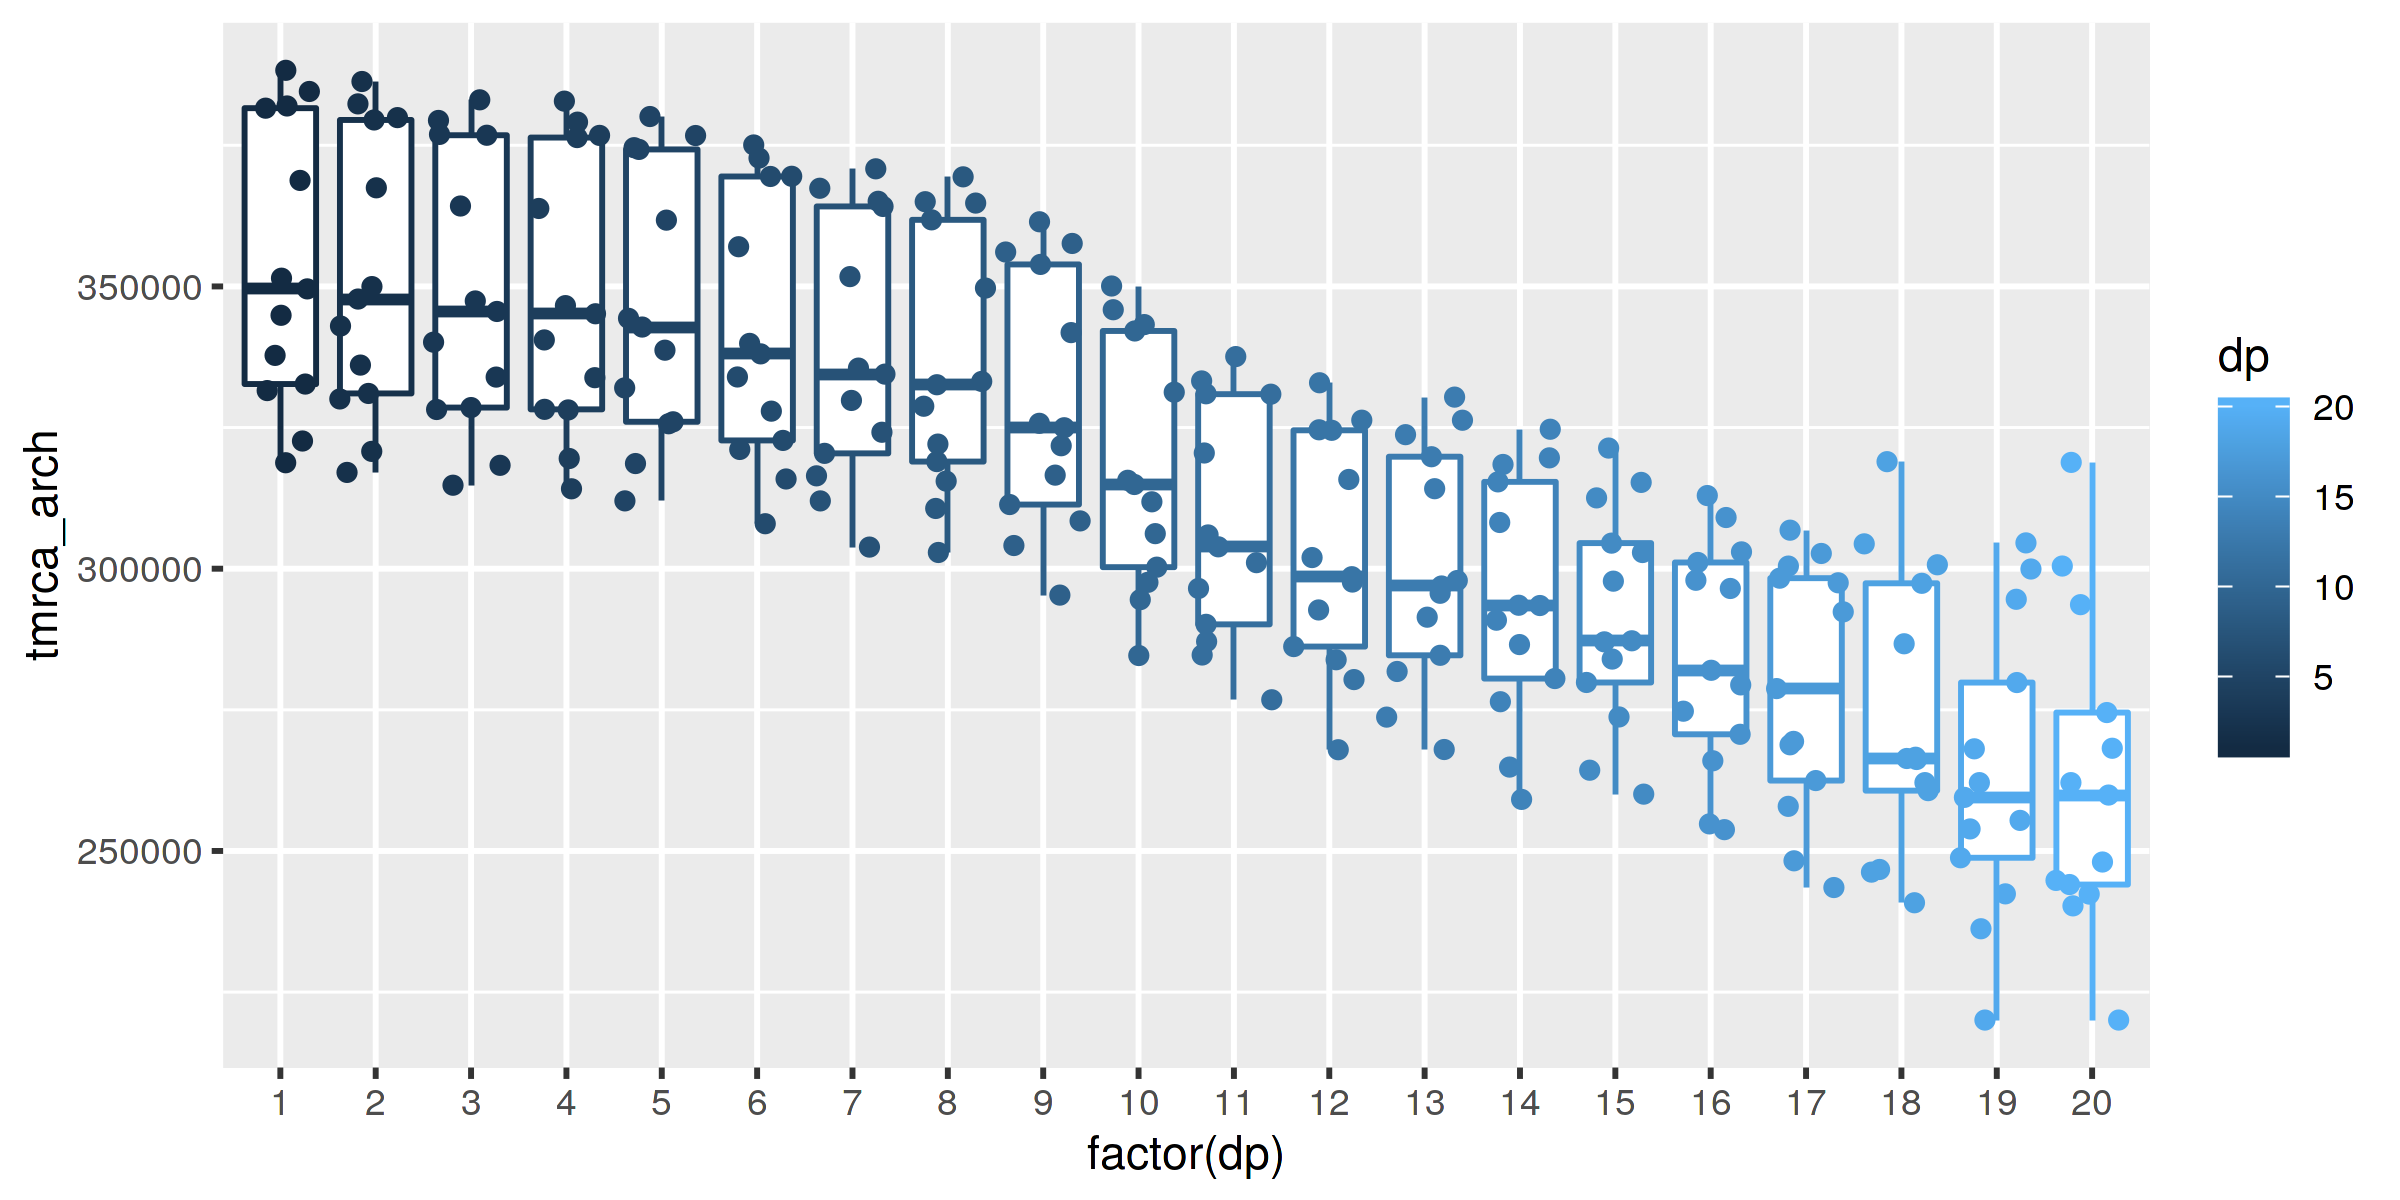

In [26]:
set_dim(8, 4)

tmrca_df %>%
filter(sites == "tv_only", arch == "mez2") %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
ggplot(aes(factor(dp), tmrca_arch, color = dp)) + geom_boxplot() + geom_jitter()

In [31]:
tmrca_df %>% filter(sites == "tv_only", arch == "mez2", capture == "full", dp == 3, afr == "a00") %>%
unnest(counts_arch) %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,dp,a,b,c,d,e,f,total
mez2,349422.9,1.429,265532.1,286552.9,244511.3,7.122598e-10,3,205,10.69231,13.23077,450.5385,505.3077,493.7692,4429566


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.98”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.02”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0804”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“span too small.   fewer data values t

“neighborhood radius 2.02”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“reciprocal condition number  0”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“There are other near singularities as well. 4.0804”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.98”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.02”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess

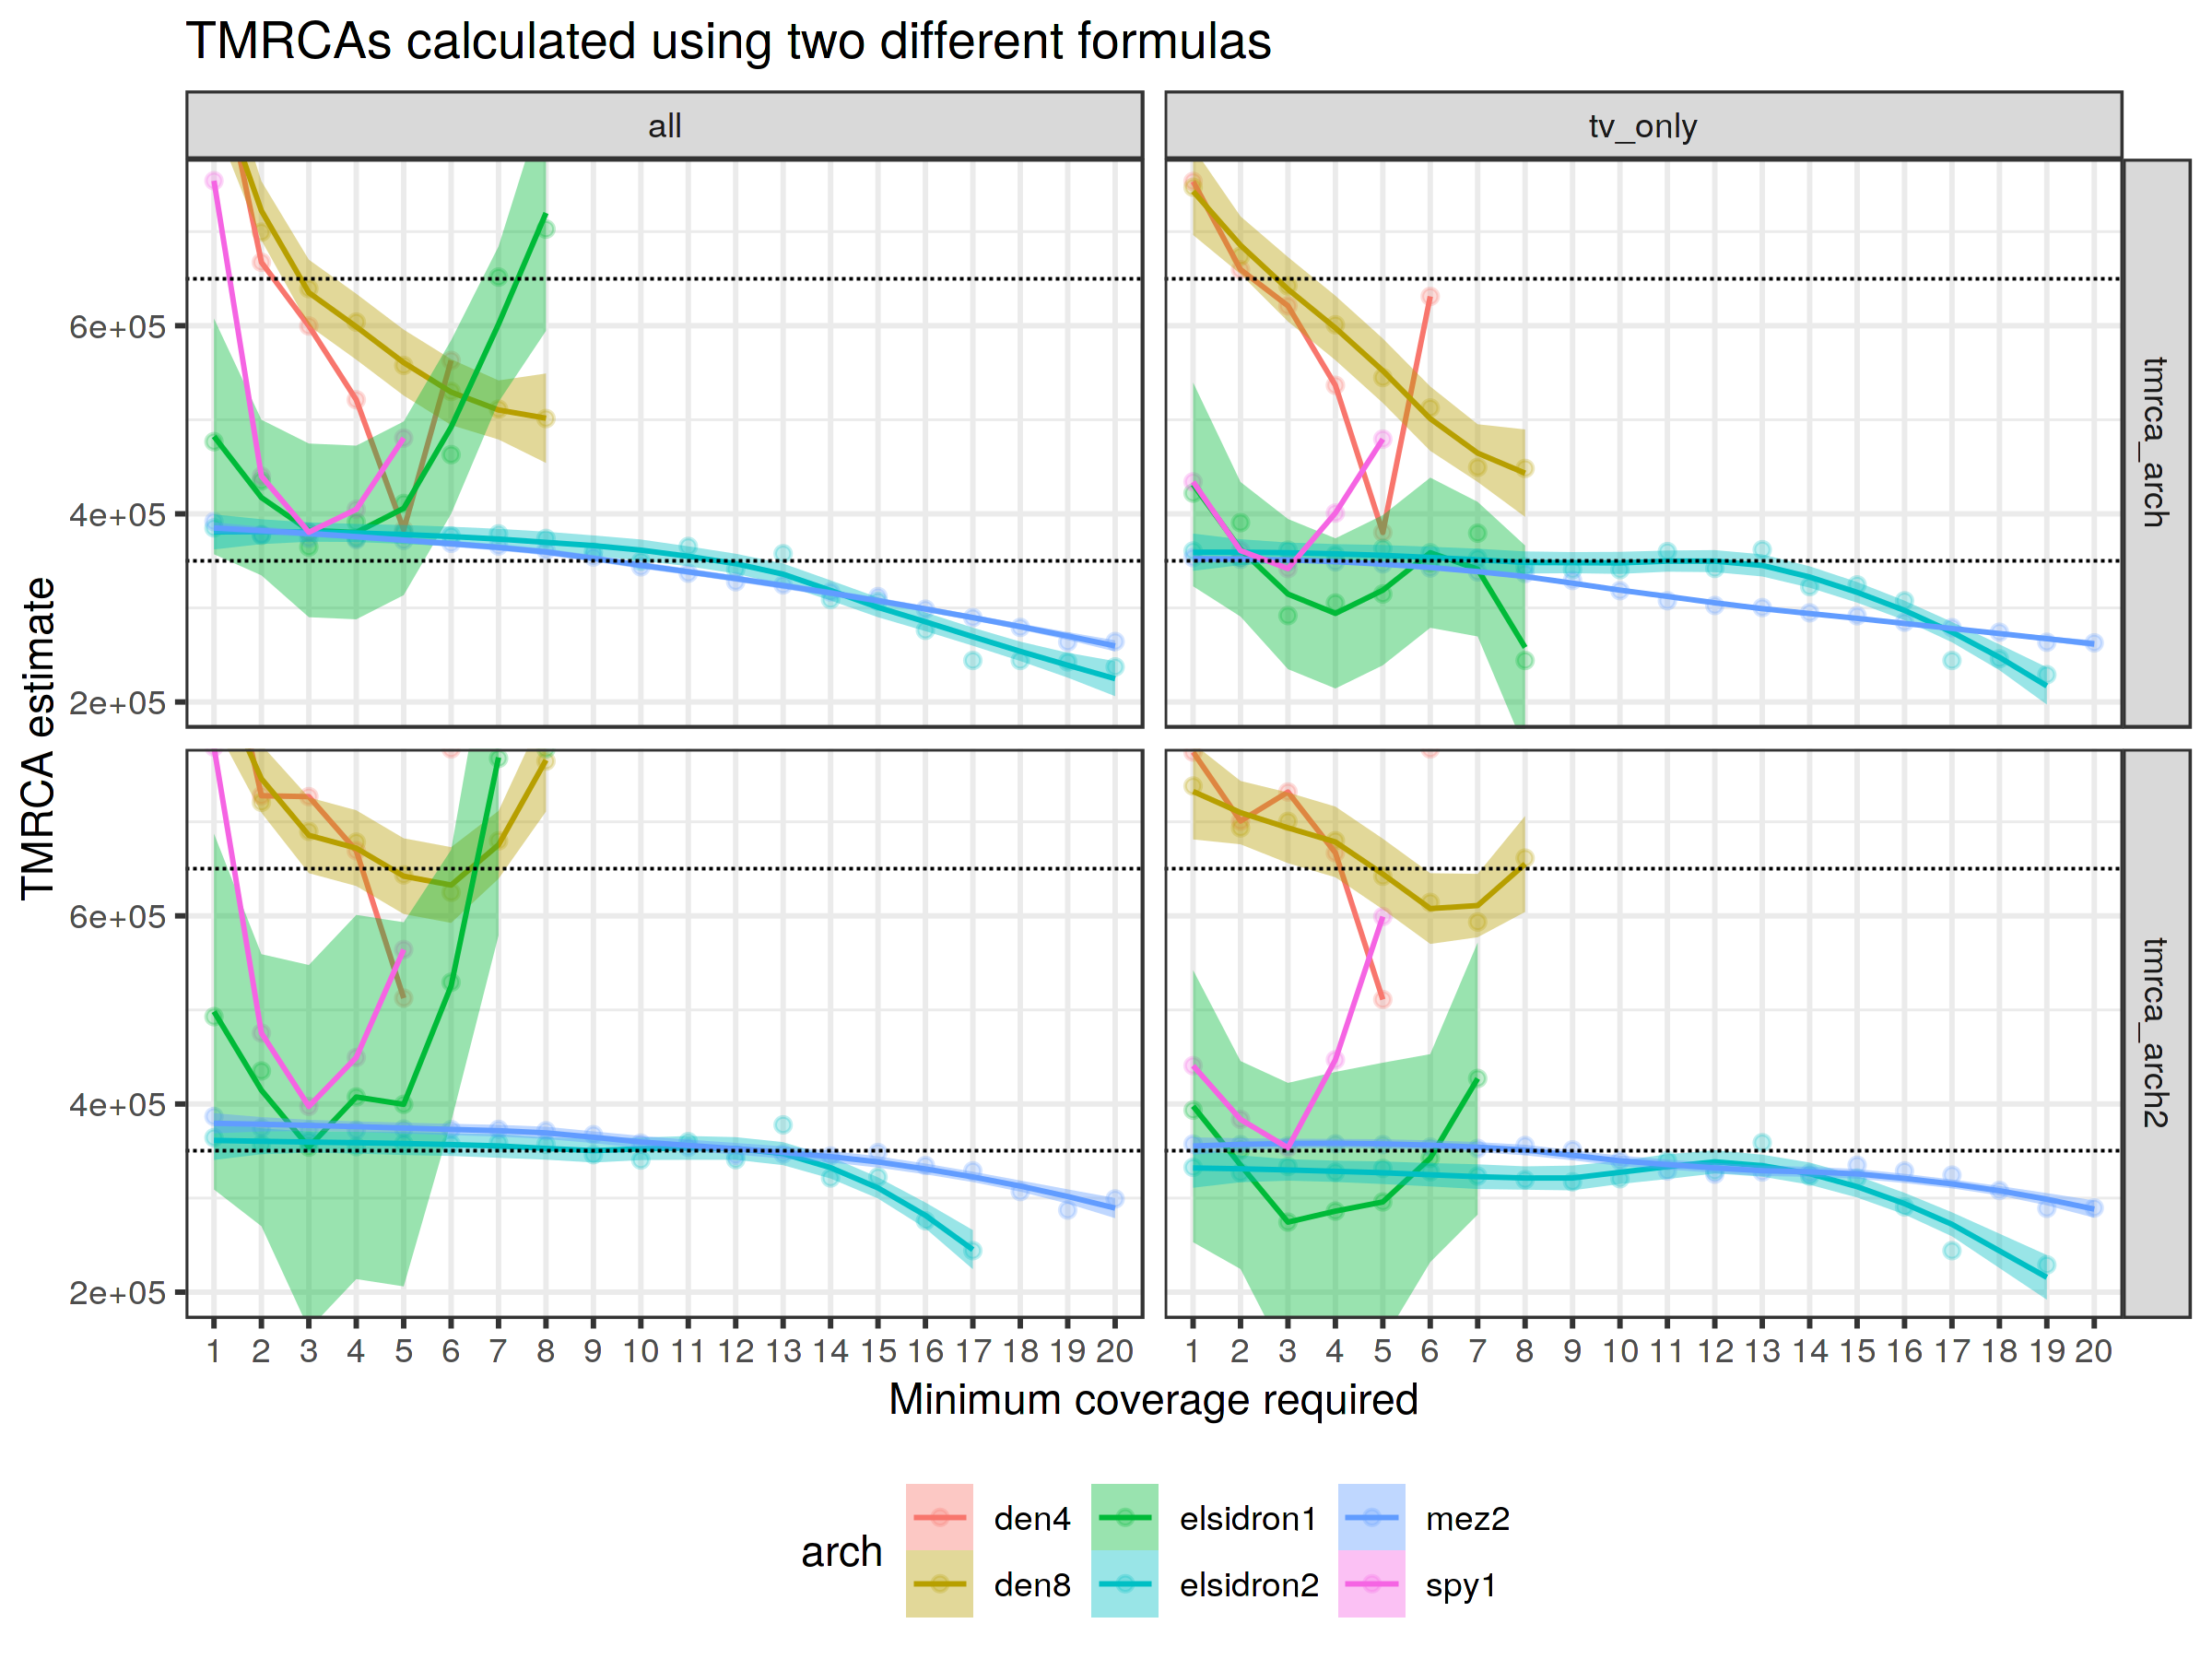

In [34]:
set_dim(8, 6)

tmrca_df %>%
filter(afr == "a00") %>%
filter(capture == "full" & arch %in% c("den8", "mez2", "spy1", "den4") | capture == "lippold" & arch == "elsidron2" | capture == "exome" & arch == "elsidron1") %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, sites, dp) %>%
group_by(arch, sites, dp) %>% summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    coord_cartesian(y = c(200000, 750000)) +
    facet_grid(tmrca ~ sites) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


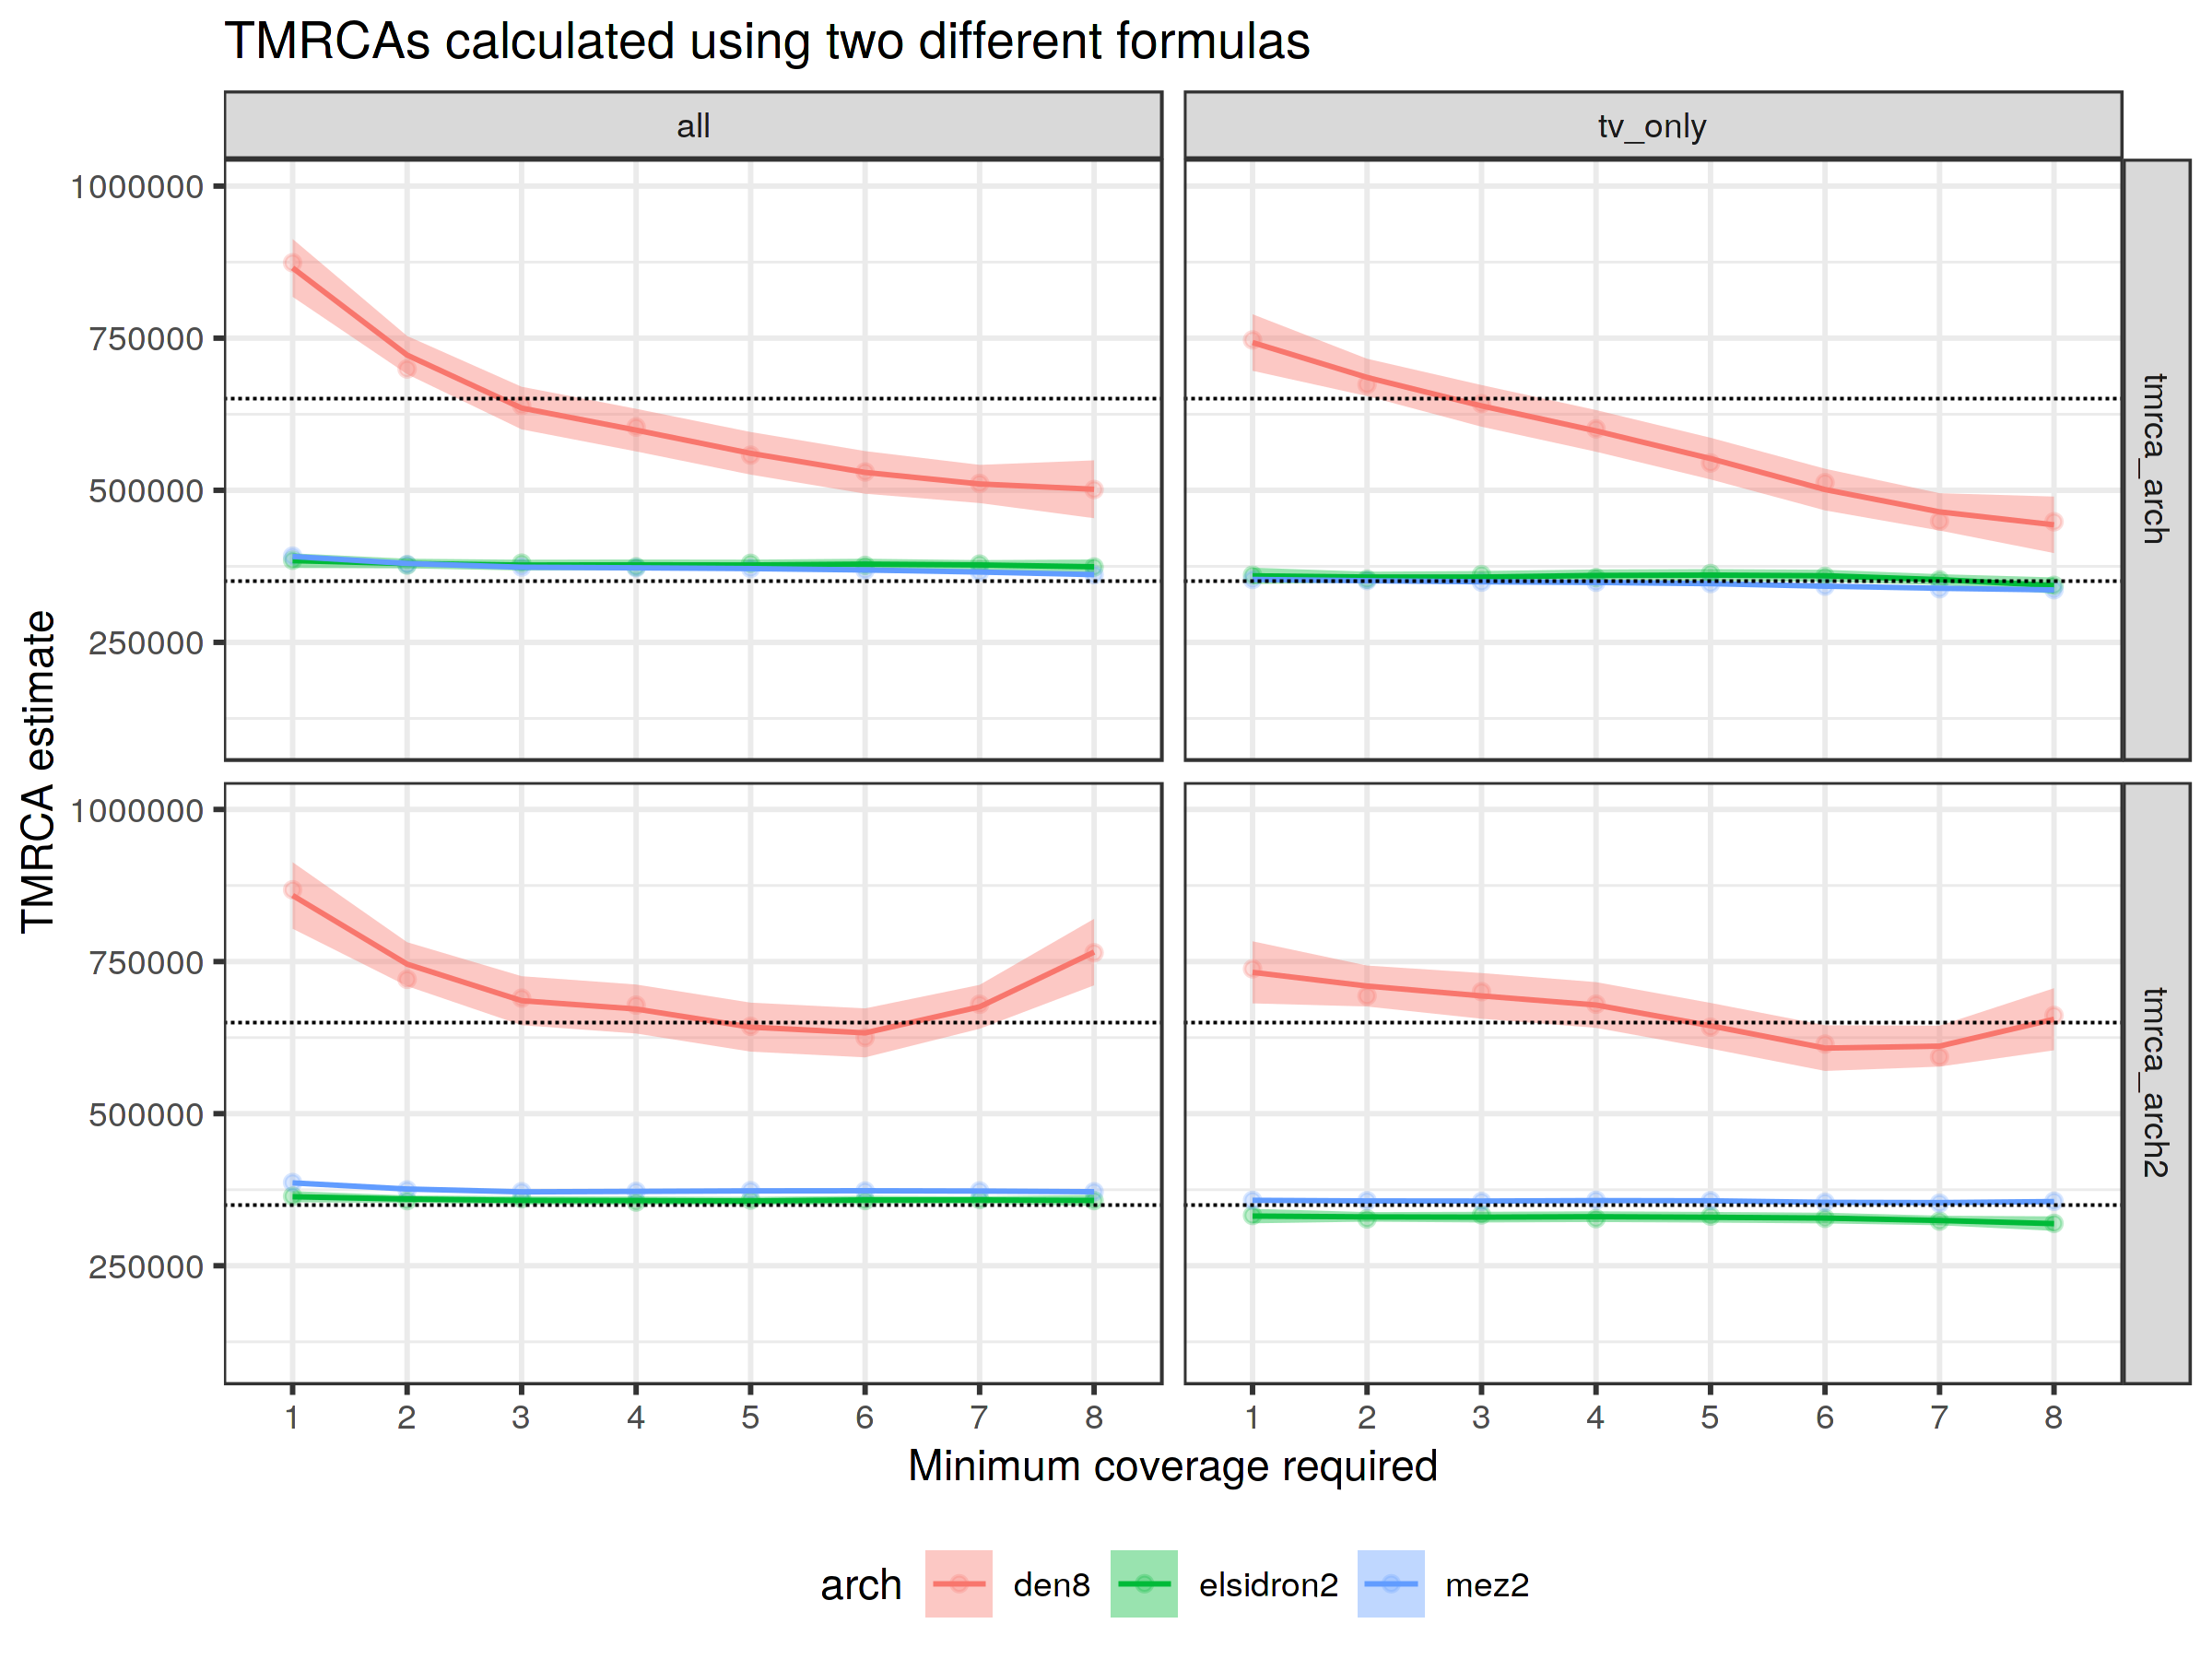

In [35]:
set_dim(8, 6)

tmrca_df %>%
filter(afr == "a00", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2") %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, sites, dp) %>%
group_by(arch, sites, dp) %>% summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    coord_cartesian(y = c(100000, 1000000)) +
    facet_grid(tmrca ~ sites) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

# Why do `d` and `e` counts differ so much depending on coverage?

# How does that depend on a chosen African?

In [53]:
set_dim(6, 3)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00") %>%
filter(capture == "full" & arch %in% c("den8"), sites == "all") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>% select(-starts_with("tmrca"), -mut_rate) %>%
group_by(arch, afr, dp) %>%
summarise_if(is.numeric, mean) %>%
arrange(dp) %>%
mutate(d_a = d / a, e_a = e / a, d_e = d / e)

arch,afr,dp,alpha,a,b,c,d,e,f,total,n_muts,d_a,e_a,d_e
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
den8,a00,1,3.579503,2196.23077,60.0000000,23.769231,860.00000,842.92308,20423.07692,4922861.4,24406.0000,0.3915800,0.3838044,1.0202592
den8,a00,2,2.865050,1274.61538,42.4615385,18.923077,653.23077,713.76923,2825.30769,4131217.8,5528.3077,0.5124925,0.5599879,0.9151848
den8,a00,3,2.618846,826.76923,32.2307692,13.461538,453.23077,568.38462,1074.15385,3228660.8,2968.2308,0.5481950,0.6874767,0.7974015
den8,a00,4,2.473522,510.92308,21.6153846,10.384615,287.61538,406.07692,607.61538,2342632.3,1844.2308,0.5629329,0.7947907,0.7082781
den8,a00,5,2.285260,282.92308,7.8461538,8.692308,173.15385,267.30769,347.69231,1572719.0,1087.6154,0.6120174,0.9448070,0.6477698
den8,a00,6,2.171504,154.15385,3.8461538,2.307692,99.15385,164.23077,198.07692,974627.1,621.7692,0.6432136,1.0653693,0.6037471
den8,a00,7,2.094767,78.07692,0.8461538,1.615385,44.23077,98.61538,95.76923,549088.7,319.1538,0.5665025,1.2630542,0.4485179
den8,a00,8,2.053920,37.23077,0.0000000,1.230769,18.07692,52.76923,45.69231,271434.3,155.0000,0.4855372,1.4173554,0.3425656


^^^ note that the `a` length is getting A LOT shorter as we increase the coverage cutoff

d/e ~1 for DP >= 1, as it should be, because there's no reason for them to be different, really

### The following means that the `a` branch is getting increasingly shorter than `e` the higher the required coverage cutoff is

But note that it's the same even for Mez2! Probably not archaic-caused ref bias?!

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


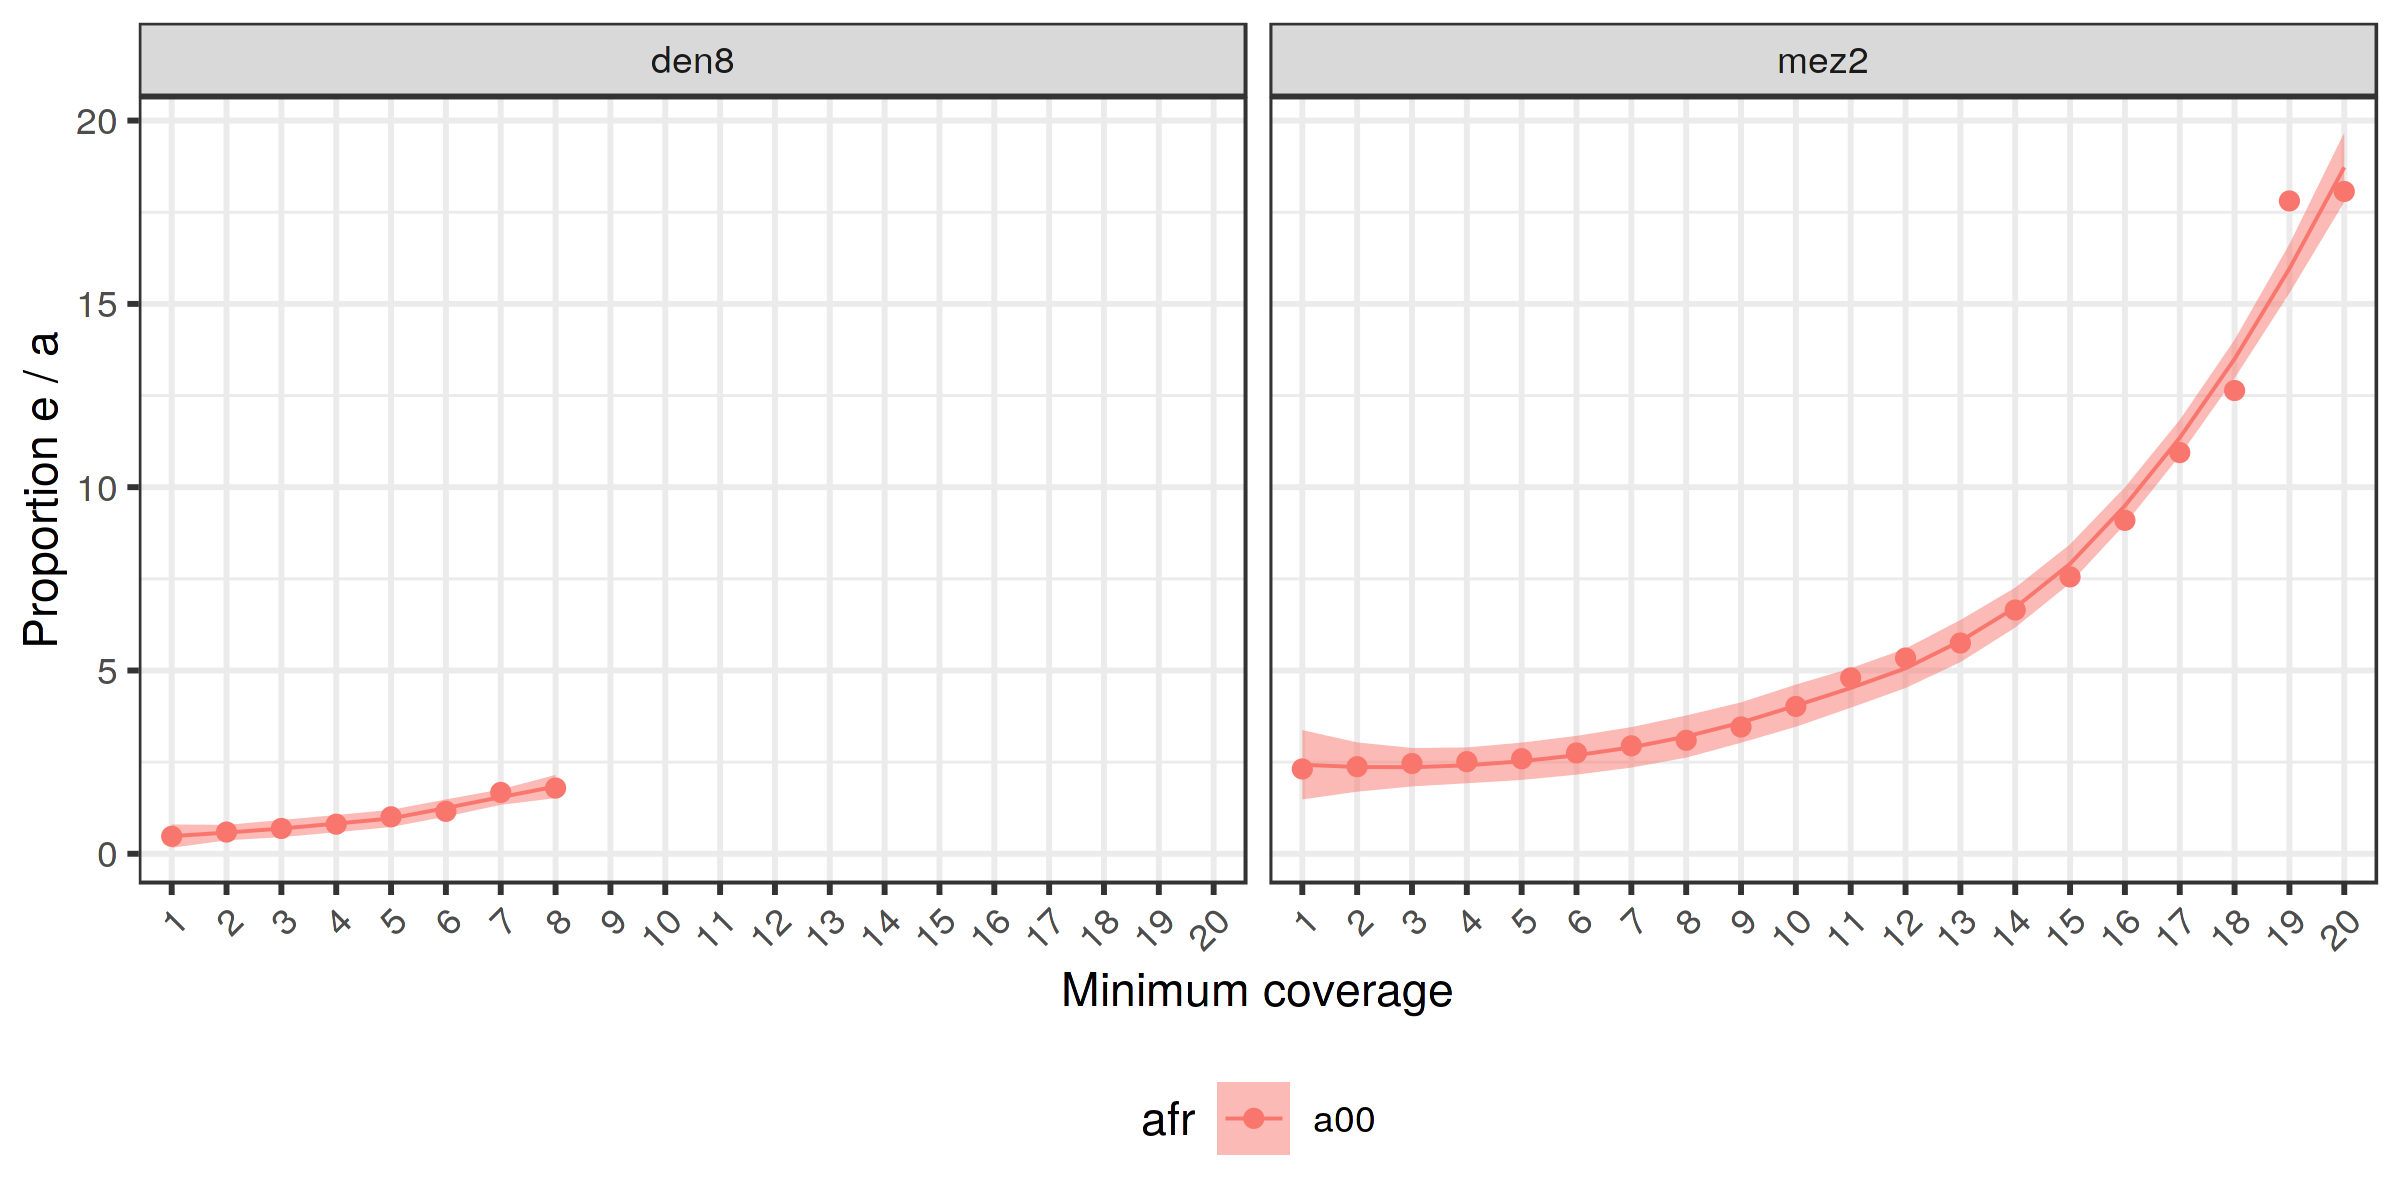

In [55]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### ... but not the `d` branch... ?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


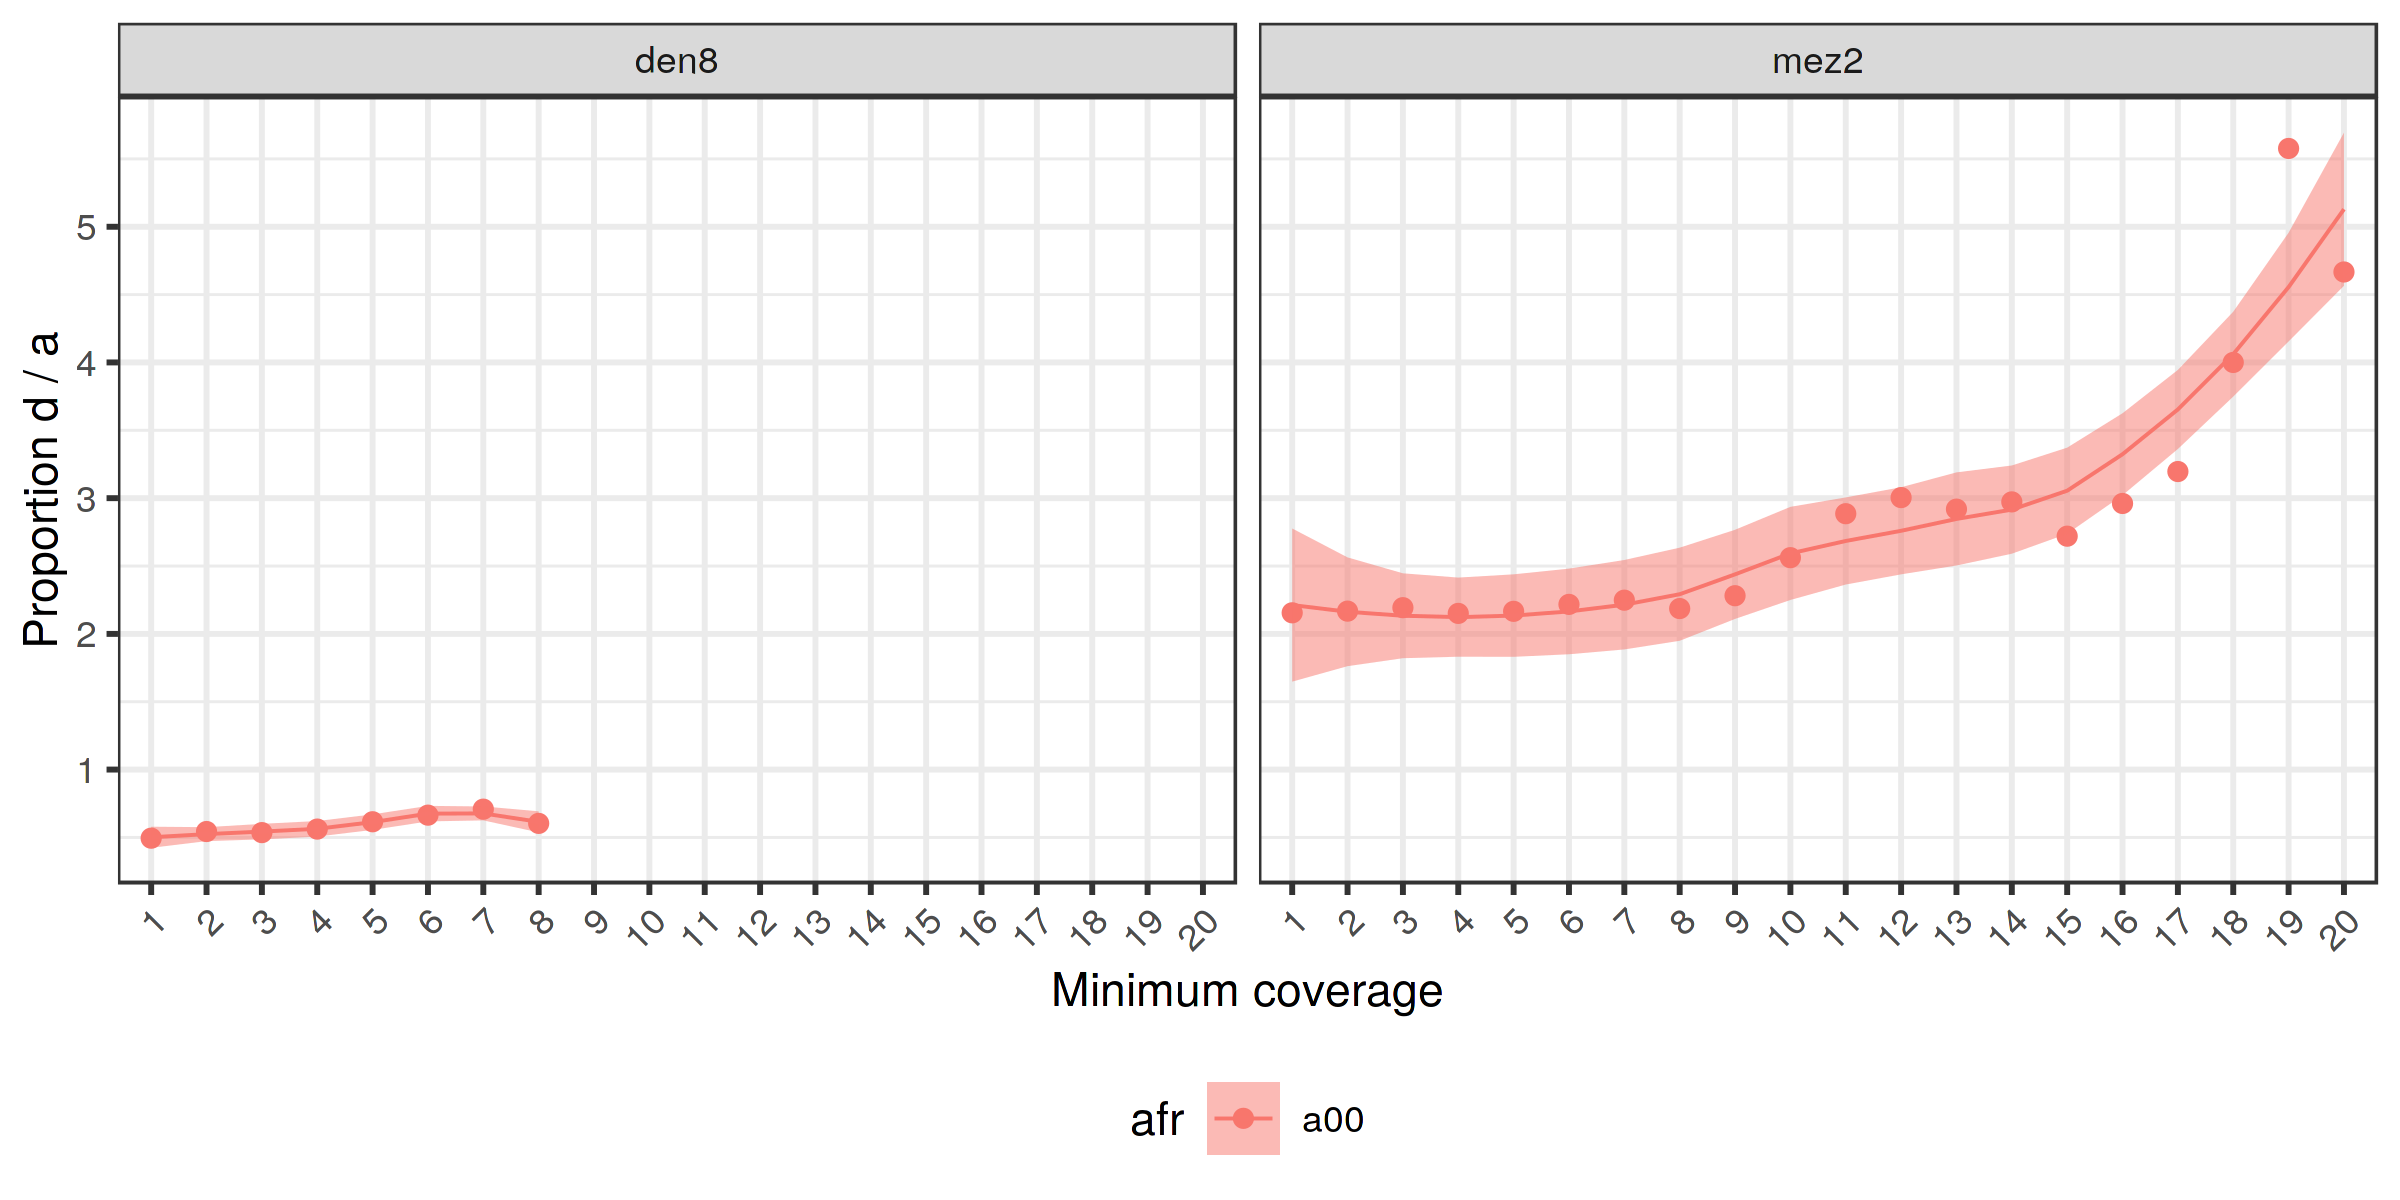

In [57]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### What about `d` vs `e`? This proportion should be ~1.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


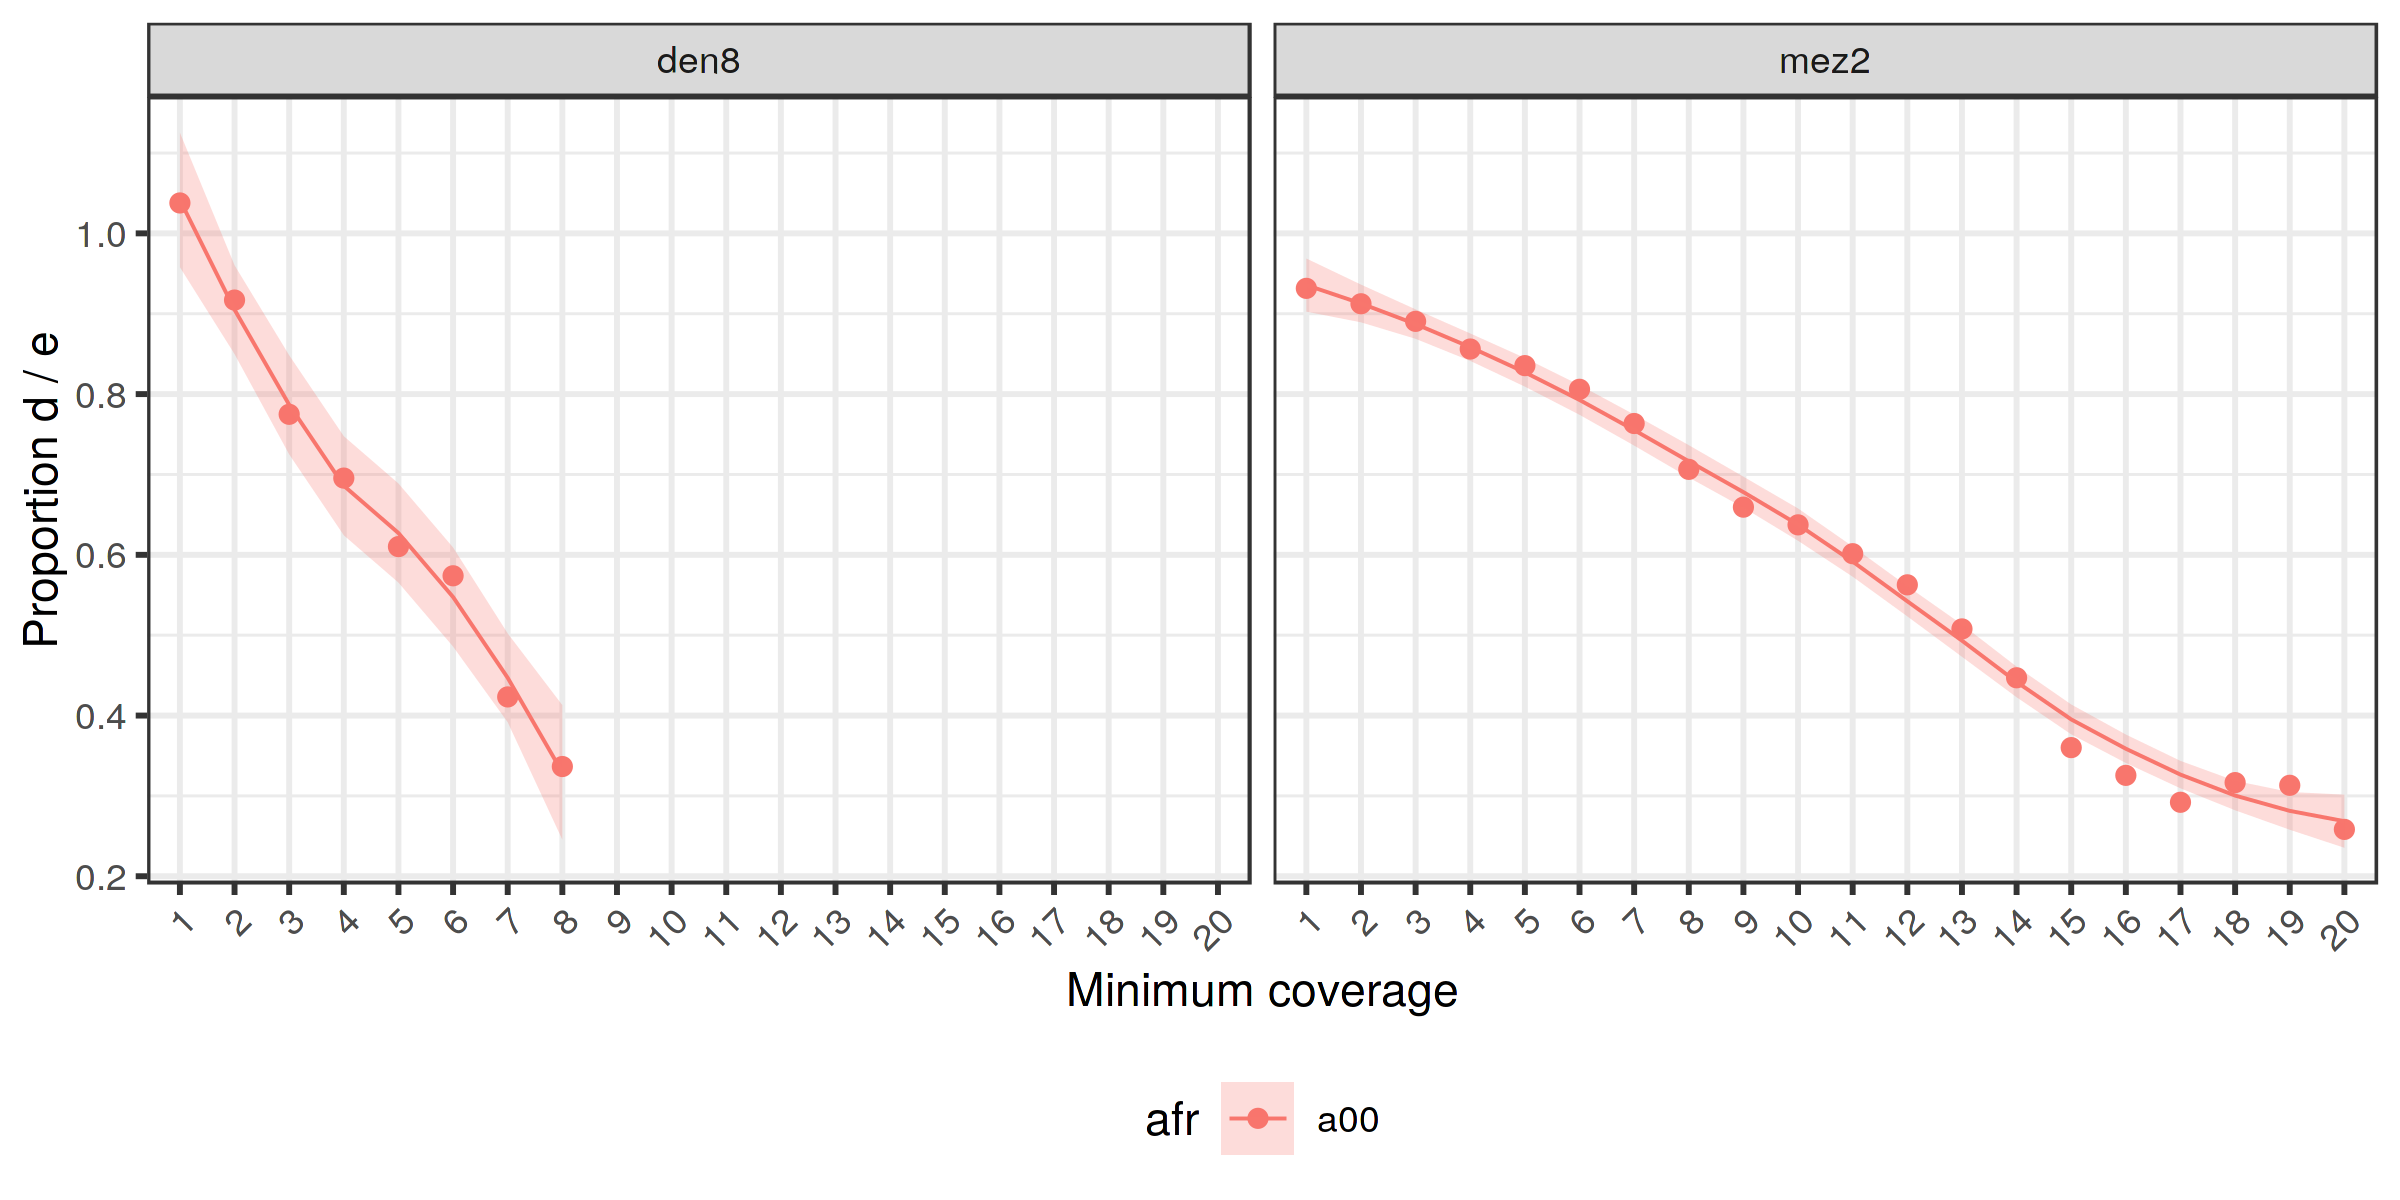

In [59]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / e) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/4) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / e") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### A00 - both `a` and `d` relatively stable across coverage, but `e` is increasing

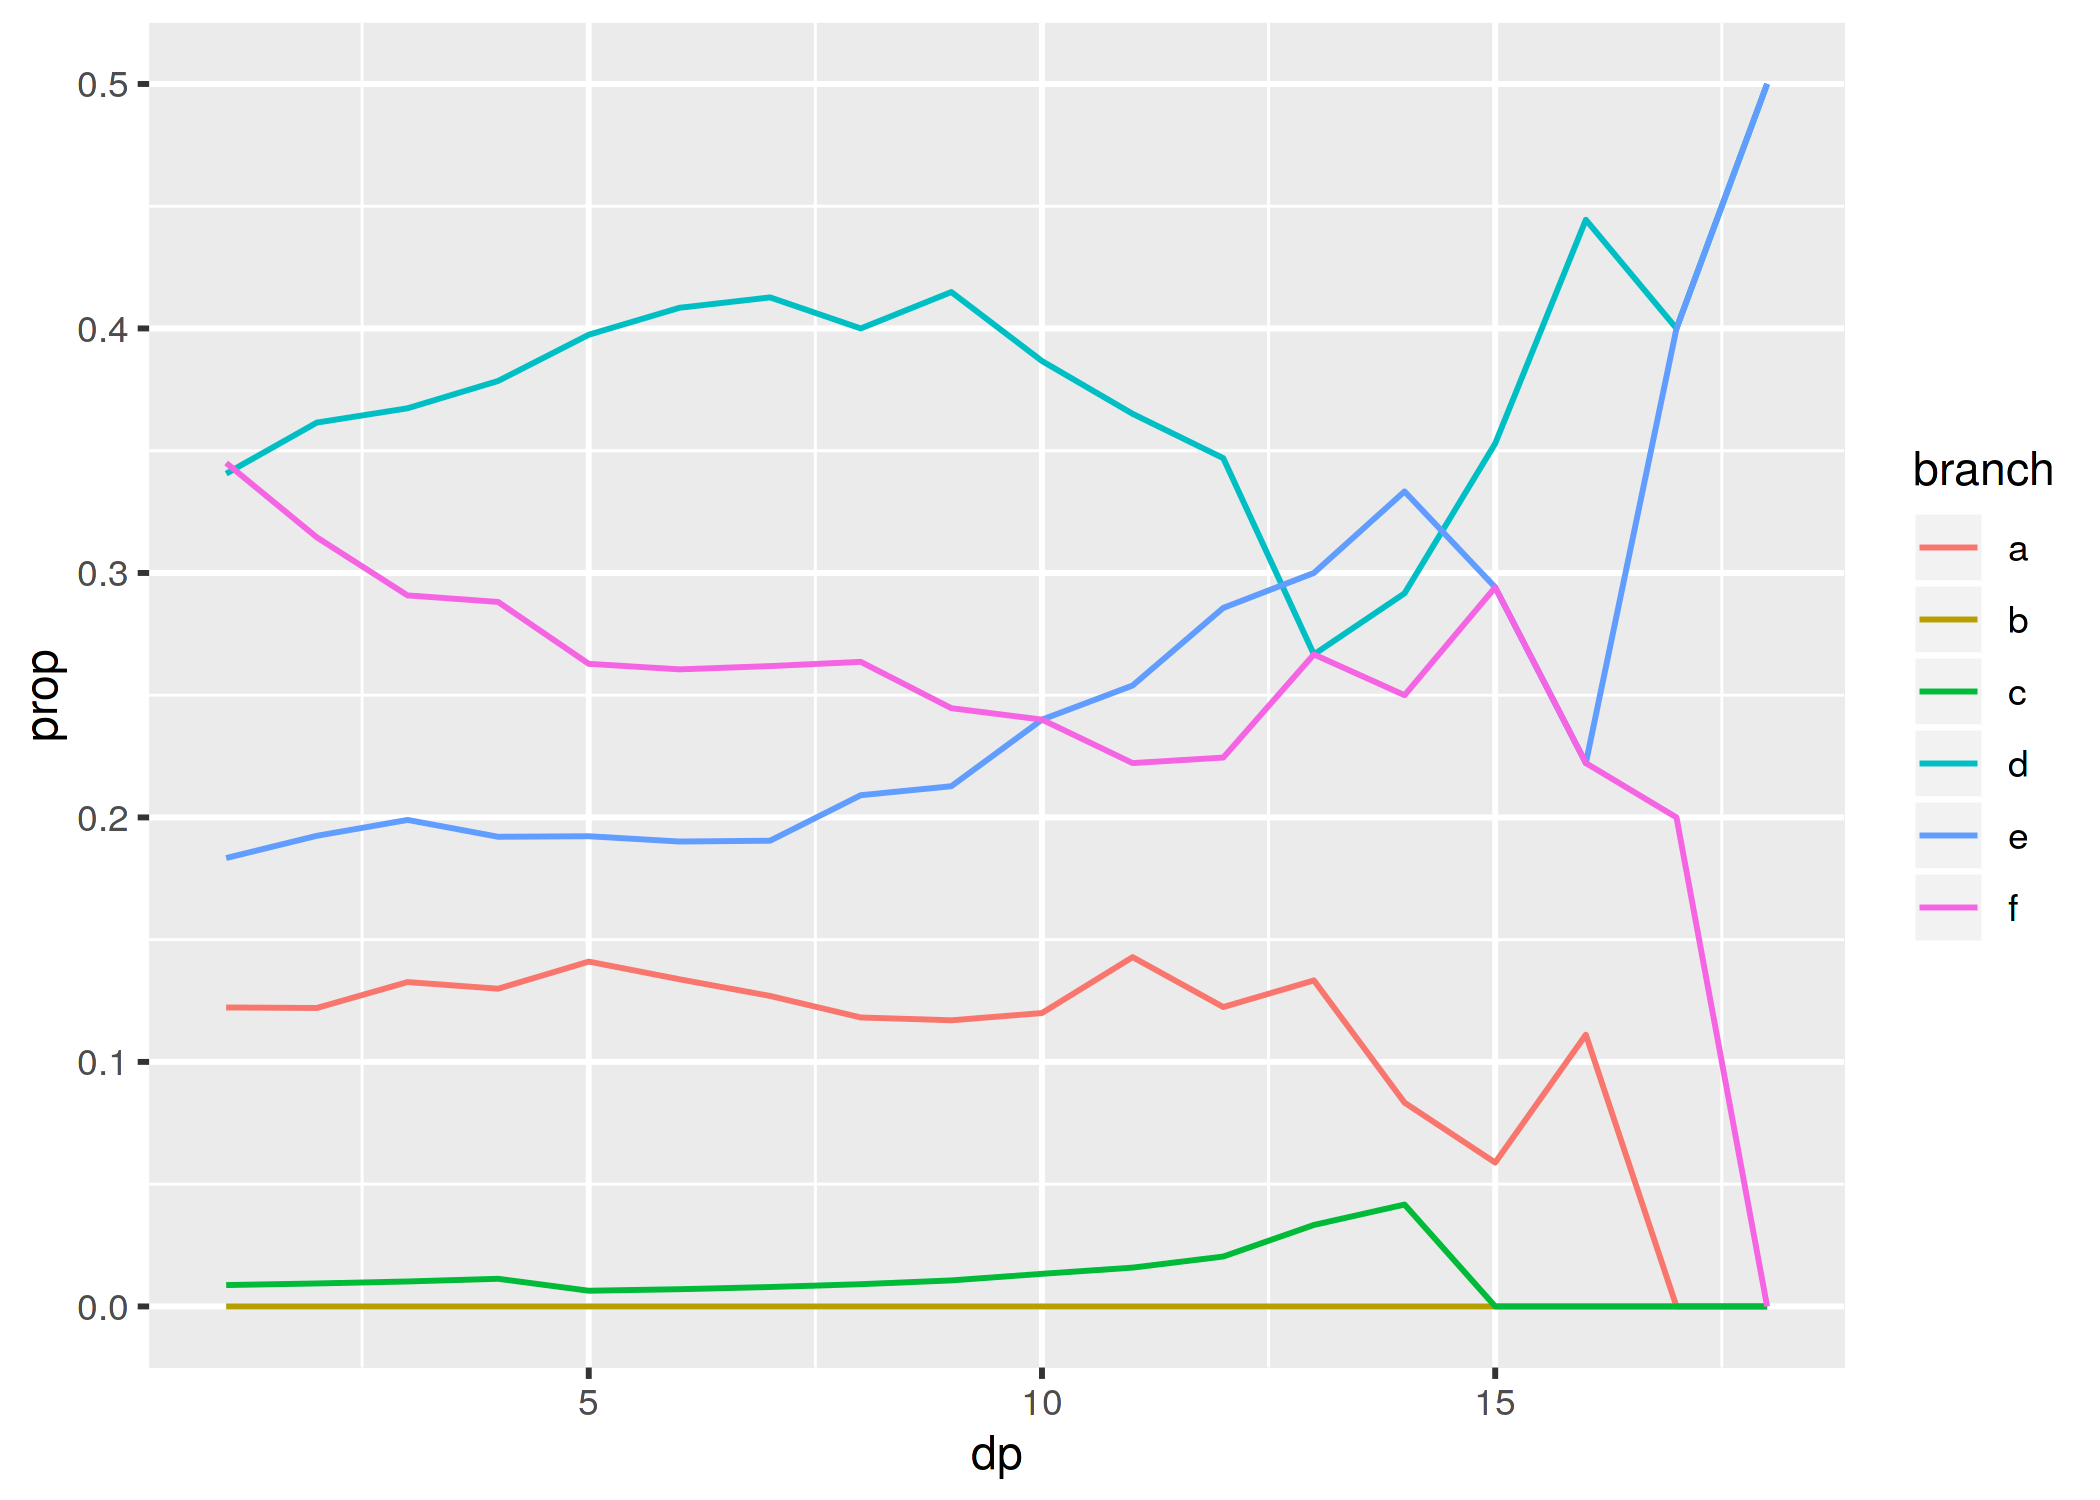

In [102]:
tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00", arch == "elsidron2", ref == "S_French_1", sites == "tv_only") %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(dp, a, b, c, d, e, f, n_muts) %>%
mutate(a = a / n_muts, b = b / n_muts, c = c / n_muts, d = d / n_muts, e = e / n_muts, f = f / n_muts) %>%
#mutate(x = a + b + c + d + e + f) %>%
gather(branch, prop, -dp, -n_muts) %>%
ggplot(aes(dp, prop, color = branch)) + geom_line()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


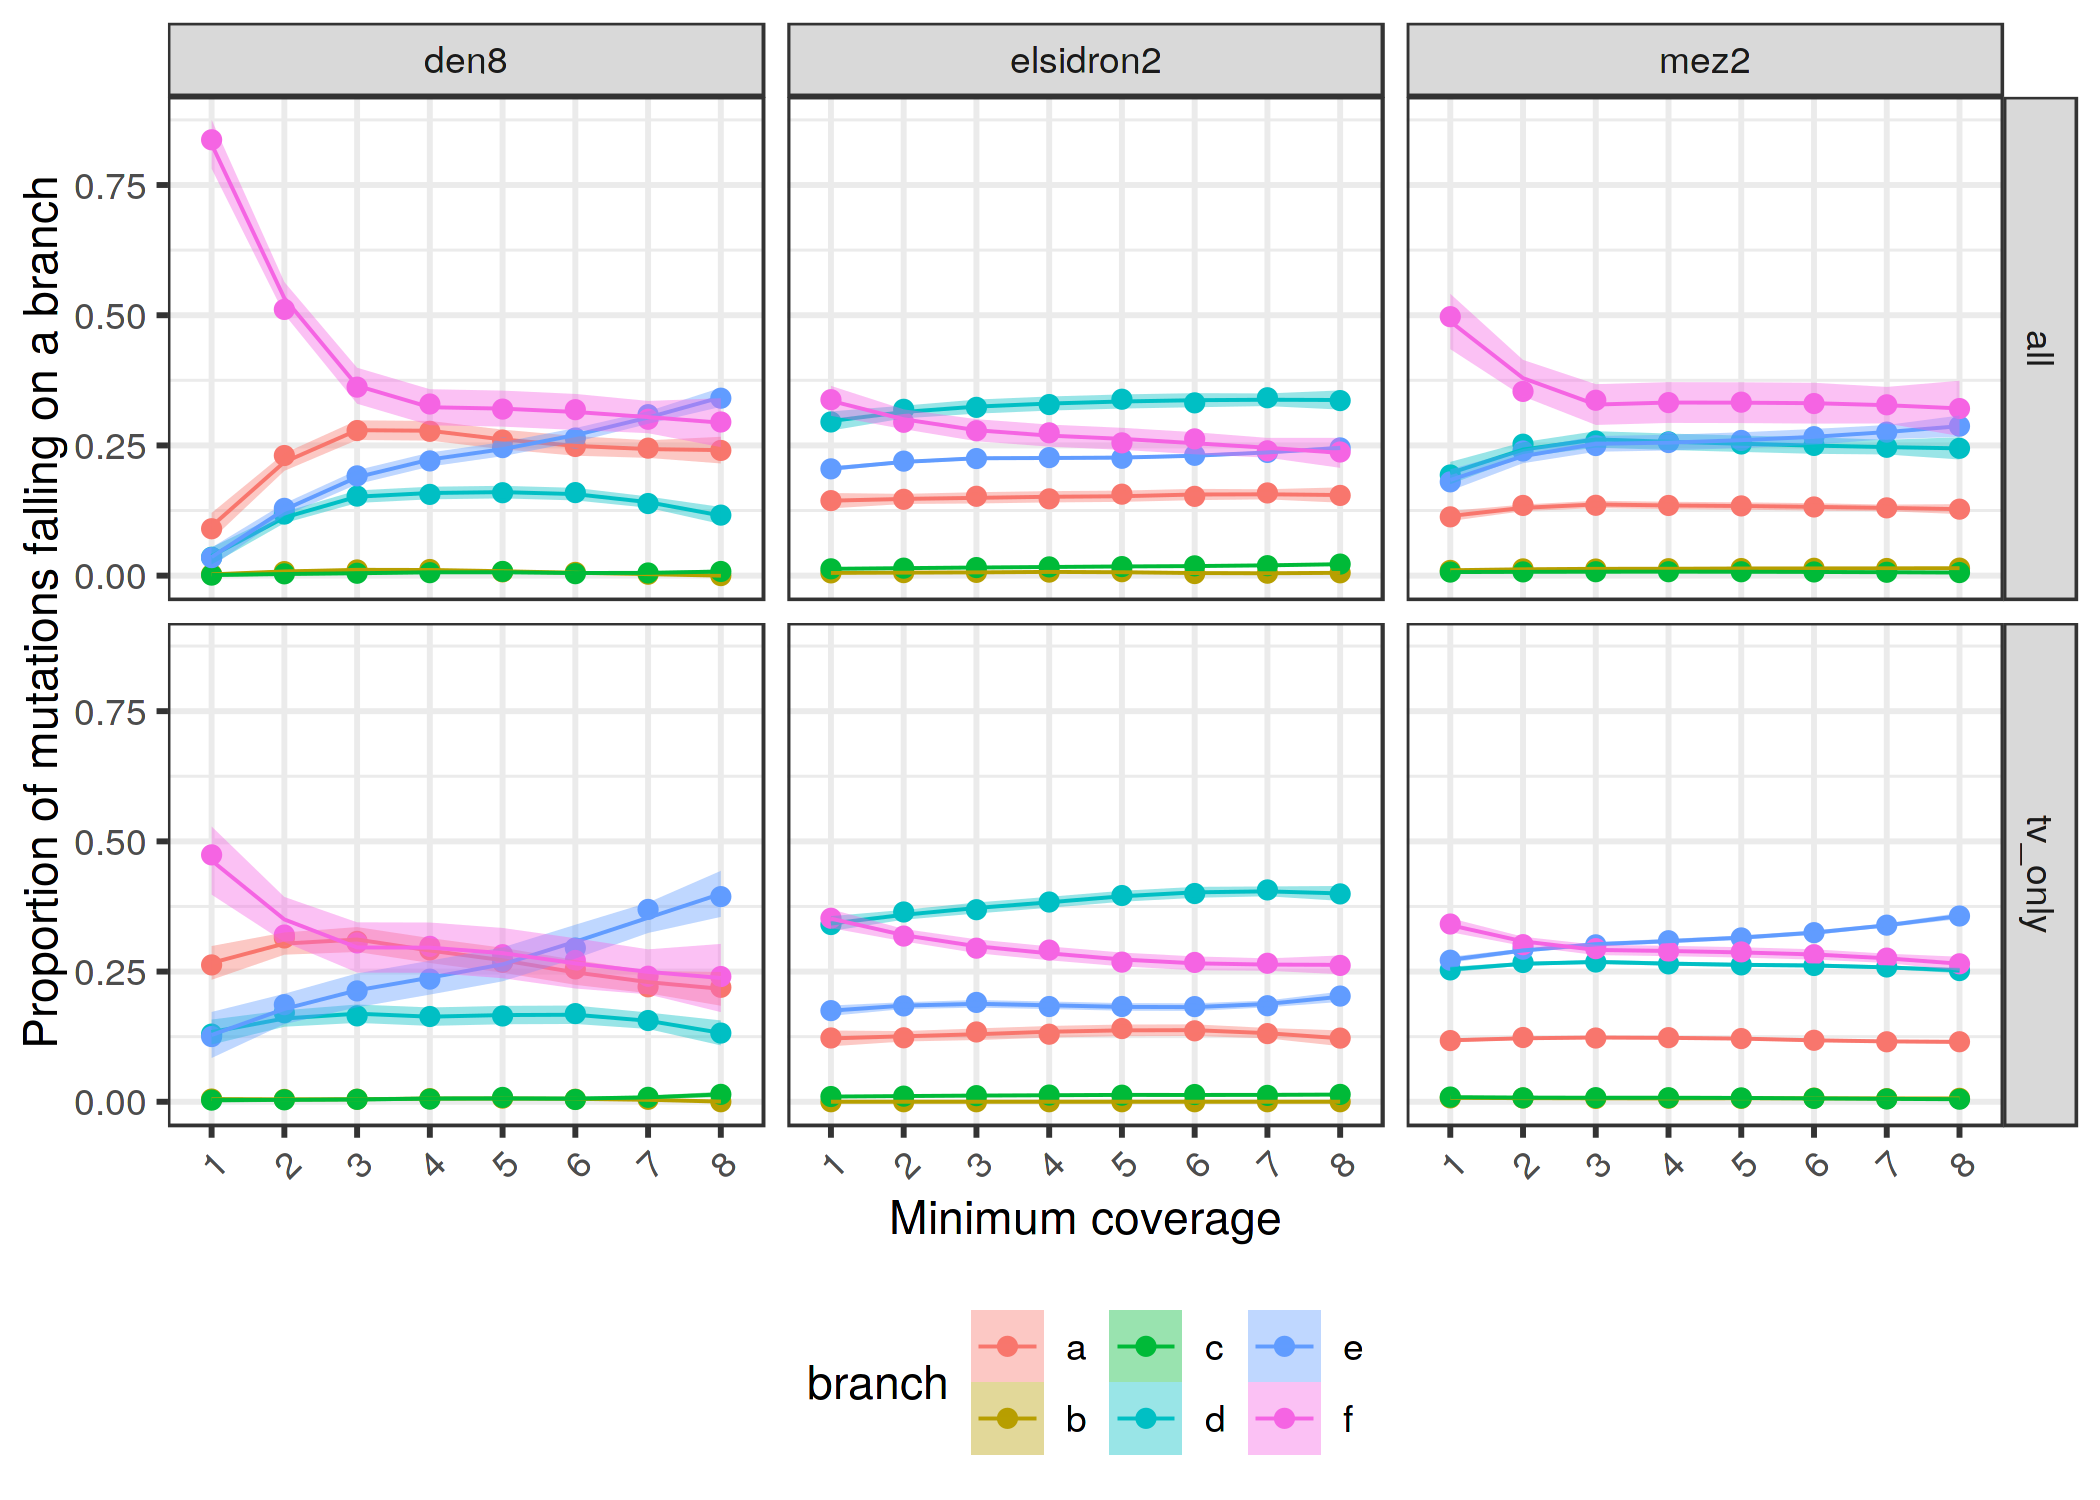

In [101]:
set_dim(7, 5)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
mutate(prop = count / n_muts) %>%
group_by(arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean) %>%
ggplot(aes(as.factor(dp), prop, color = branch, fill = branch, group = branch)) +
    geom_point() +
    geom_smooth(size = 1/3) +
    facet_grid(sites ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion of mutations falling on a branch") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

^^^ `a` and `f` appear to level after `dp >= 3` which seems OK???

but `e` is increasing steadily - this is super weird and could be driving `a / (a + d + e)` higher at higher cutoffs?
* is the increased proportion of `e` branch the reference bias signal?


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


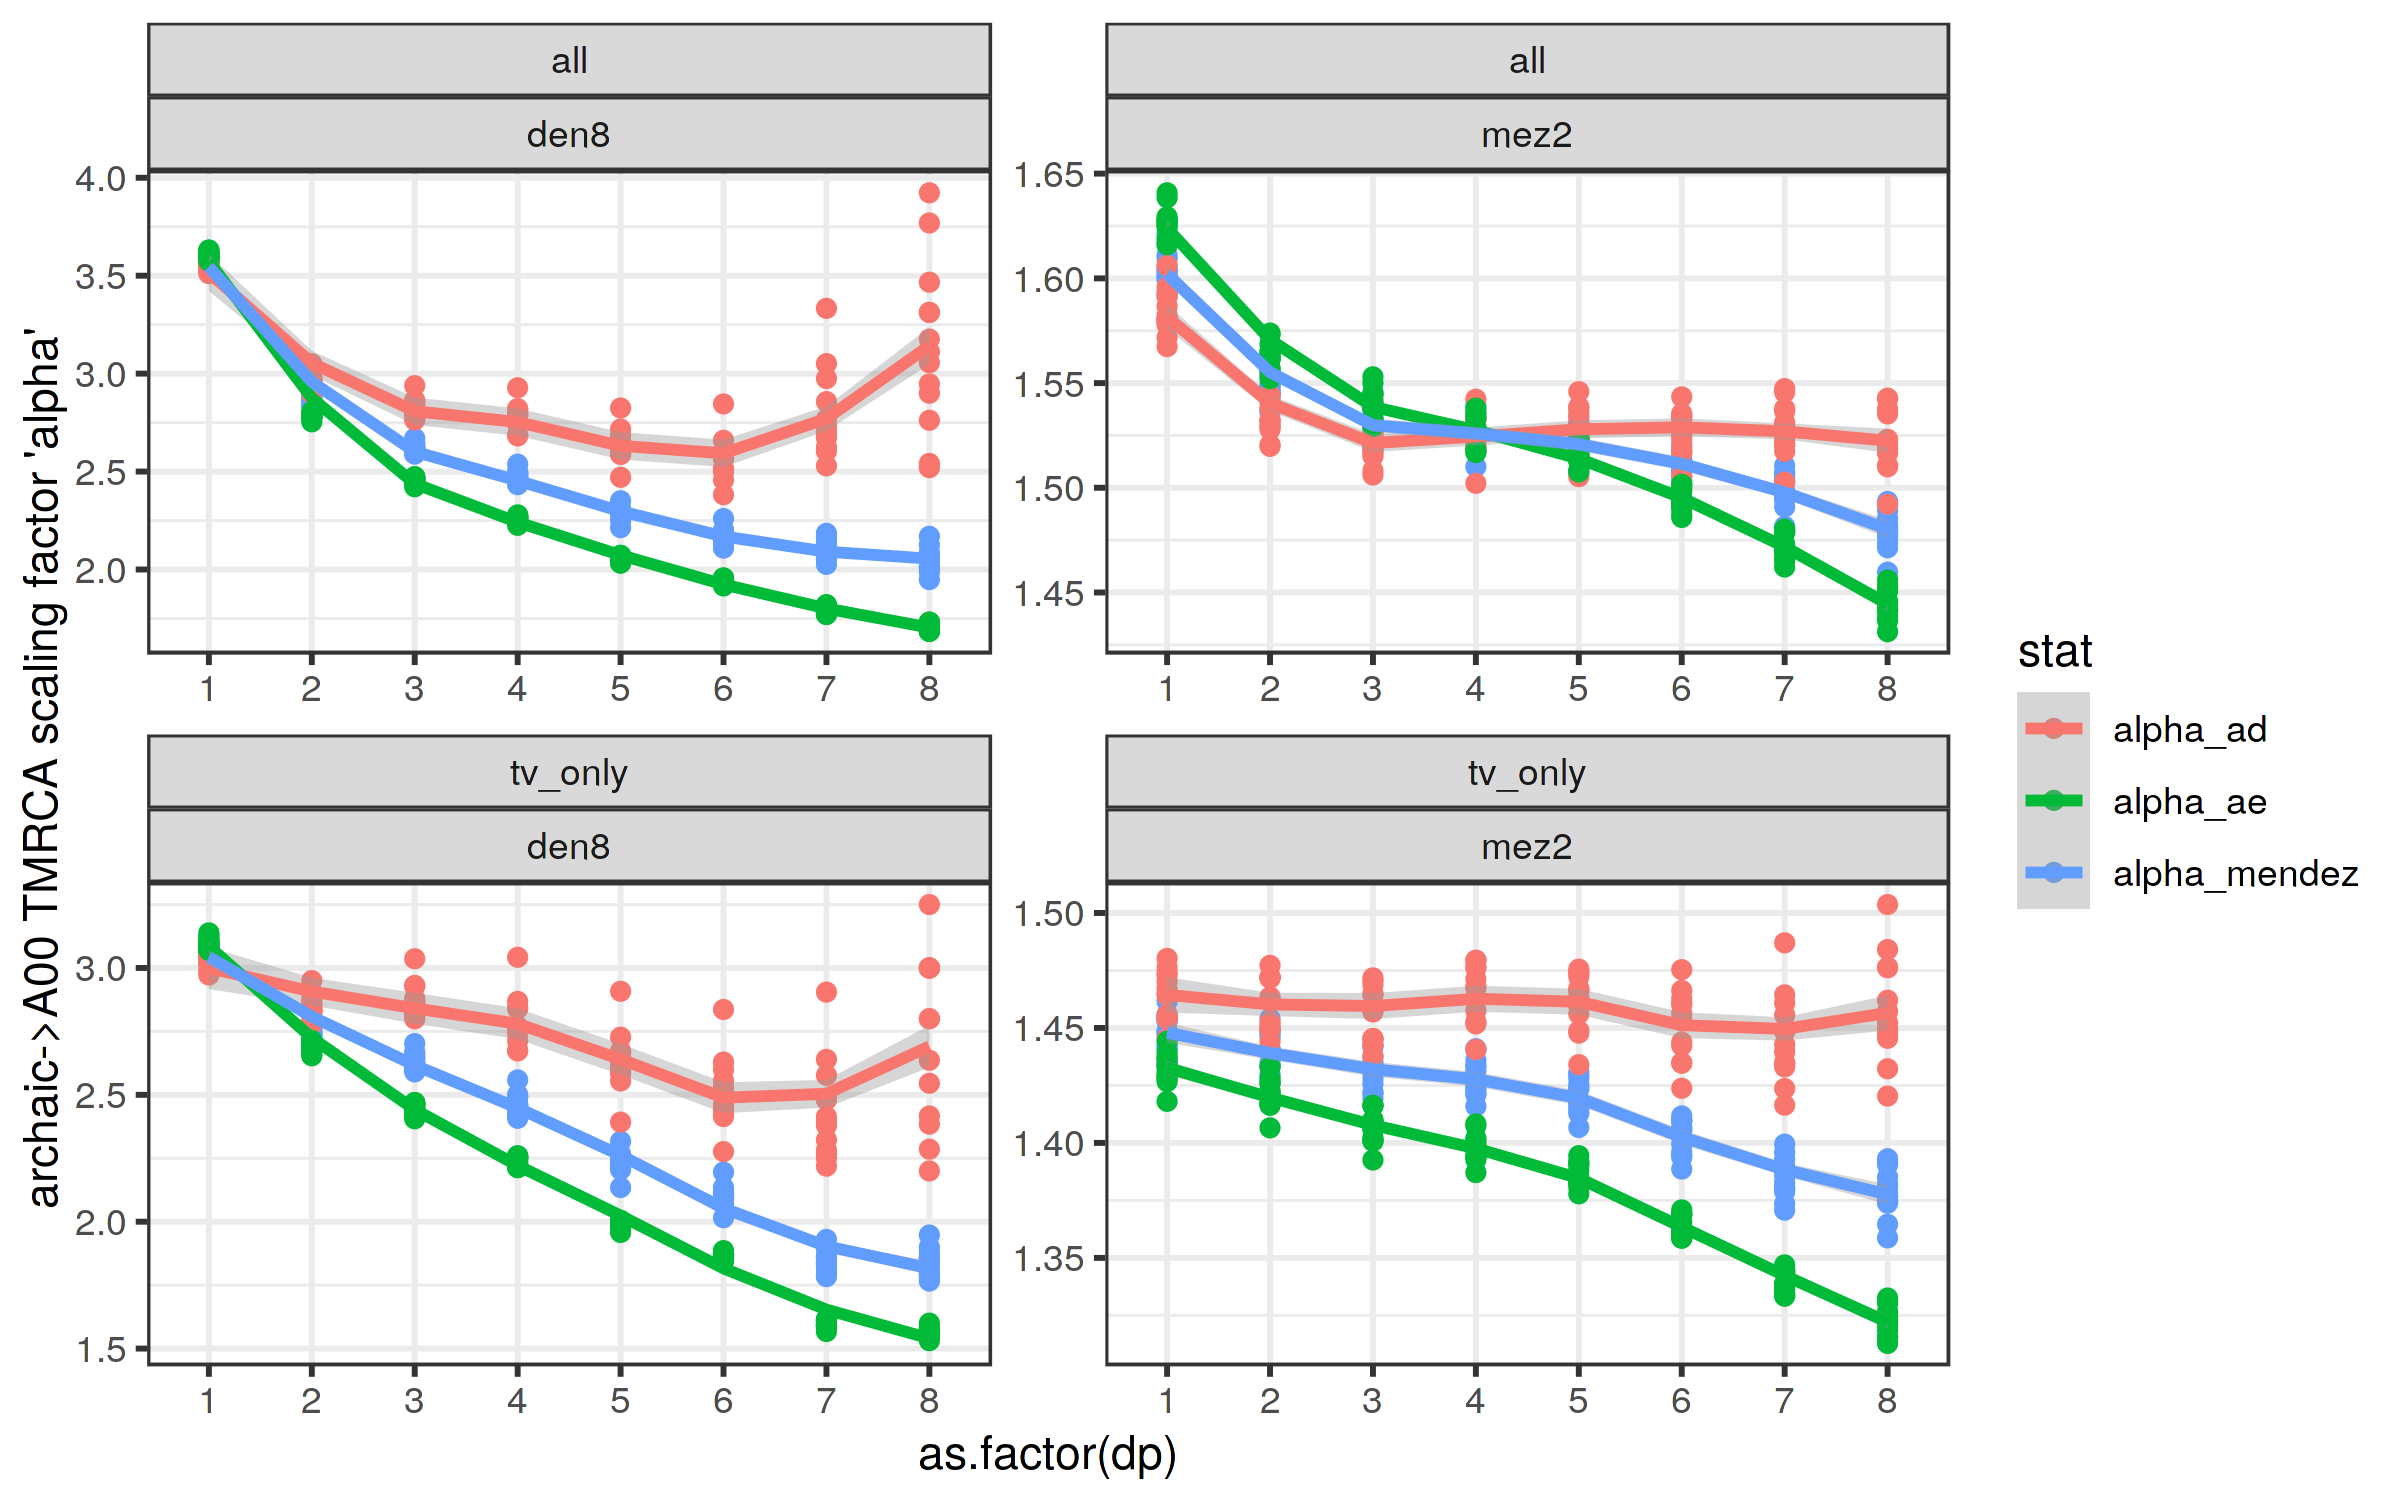

In [103]:
set_dim(8, 5)

tmrca_df %>%
filter(dp < 9, capture == "full", afr == "a00", arch %in% c("mez2", "den8")) %>% unnest(counts_arch) %>%
select(arch, dp, tmrca_arch, alpha_mendez = alpha, sites, tmrca_f, a, b, c, d, e, f) %>%
mutate(
    alpha_ad = (a + d) / d,
    alpha_ae = (a + e) / e
) %>%
select(arch, dp, sites, starts_with("alpha")) %>%
gather(stat, value, -arch, -dp, -sites) %>%
ggplot(aes(as.factor(dp), value, color = stat)) +
    geom_point() +
    geom_smooth(aes(group = stat)) +
    theme_bw() +
    facet_wrap(sites ~ arch, scales = "free") +
    ylab("archaic->A00 TMRCA scaling factor 'alpha'")

points here:

1. 3X coverage seems to remove most of the error effects nicely - best argument for using this cutoff in the middle panel.
2. TV-only removes all erors (TMRCA doesn't change) => sequencing errors minimal beyond aDNA damage.
3. Minimal effect of reference bias with increasing coverage??? Based on the Neanderthal line in the center panel, but significant bias in Denisova?

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?

In [36]:
library(scales)

colors <- c("red", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

tafr <- tmrca_df %>%
    filter(dp == 3, afr == "a00", arch == "den8", capture == "full", sites == "all") %>%
    select(name = afr, tmrca = tmrca_afr)

tarch <- tmrca_df %>%
    filter(afr == "a00") %>%
    filter(dp == 2 & sites == "tv_only" & capture == "full" & arch %in% c("den4", "den8", "mez2", "spy1", "shotgun_spy1", "shotgun_mez2") |
           dp == 2 & sites == "tv_only" & capture == "lippold" & arch == "elsidron2" |
           dp %in% c(1, 3) & sites == "all" & capture == "exome" & arch == "elsidron1") %>%
    mutate(arch = case_when(arch == "elsidron1" & dp == 1 ~ "elsidron_dp1",
                            arch == "elsidron1" & dp == 3 ~ "elsidron_dp3",
                            TRUE ~ arch)) %>%
    select(name = arch, tmrca = tmrca_arch, tmrca_arch2)
tmrca <- bind_rows(tafr, tarch) %>%
    mutate(set = case_when(name == "a00" ~ "A00",
                       name %in% c("den4", "den8") ~ "Denisovan",
                       name %in% c("spy1", "mez2", "elsidron2", "shotgun_spy1", "shotgun_mez2") ~ "Neanderthal",
                       TRUE ~ "other")) %>%
    mutate(name = case_when(name == "den4" ~ "Denisova 4 (1.6X)",
                            name == "den8" ~ "Denisova 8 (3.6X)",
                            name == "elsidron2" ~ "El Sidron (8X)",
                            name == "mez2" ~ "Mezmaiskaya 2 (15X)",
                            name == "spy1" ~ "Spy 1 (0.9X)",
                            name == "shotgun_spy1" ~ "Spy1 shot",
                            name == "shotgun_mez2" ~ "Mez2 shot",
                            name == "elsidron_dp1" ~ "El Sidron (3X, Mendez et al.)",
                            name == "elsidron_dp3" ~ "El Sidron (3X, Mendez at al., filtered)",
                            name == "a00" ~ "A00 lineage (21X)")) %>%
    mutate(name = fct_relevel(name, "El Sidron (8X)", "El Sidron (3X, Mendez et al.)",
                              "El Sidron (3X, Mendez at al., filtered)", "A00 lineage (21X)", after = Inf))


Attaching package: ‘scales’

The following objects are masked from ‘package:ychr’:

    col_factor, discard

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



ERROR: Error in .f(.x[[i]], ...): object 'tmrca_arch2' not found


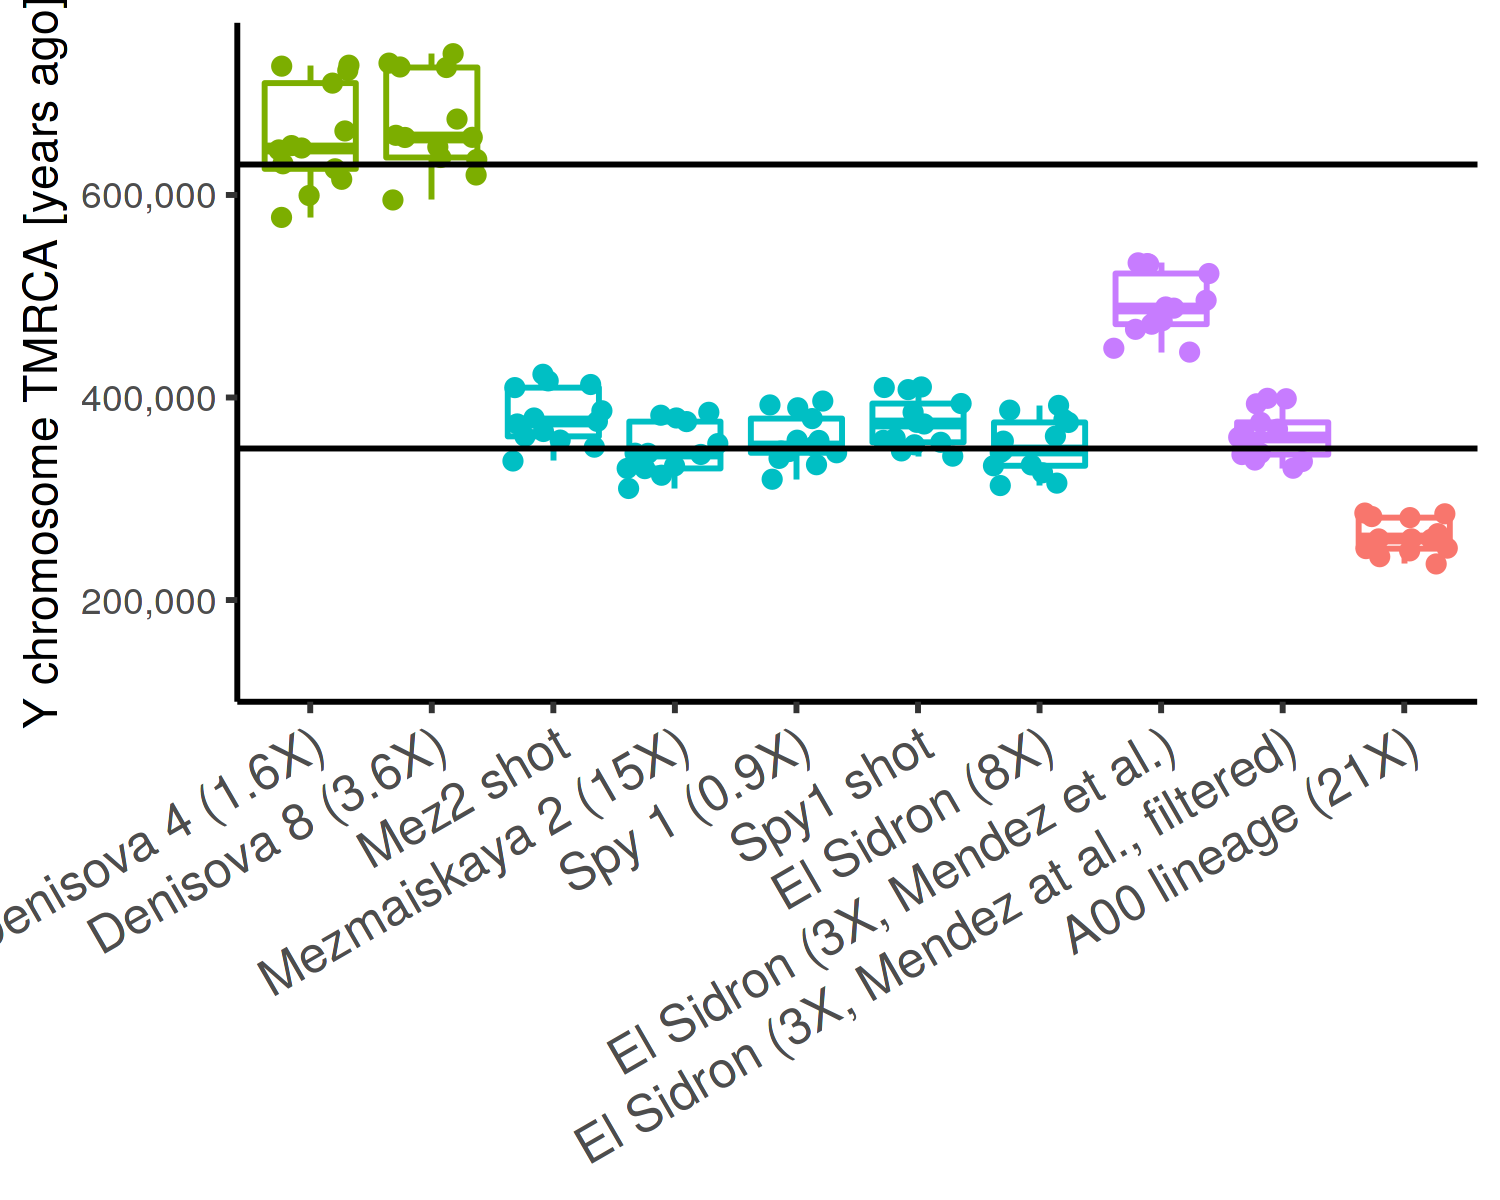

In [153]:
set_dim(5, 4)

tmrca %>%
ggplot(aes(name, tmrca, color = set)) +
    geom_boxplot() +
    geom_jitter() + 
    theme_classic() +
    xlab("") + ylab("Y chromosome TMRCA [years ago]") +
    expand_limits(y = 130000) +
    guides(color = guide_legend("archaic human")) +
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = c(630000, 350000)) +
    theme(legend.position = "none",
          axis.text.x = element_text(hjust = 1, angle = 30, size = 12),
          axis.title.x = element_blank())

Warning message:
“Removed 13 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 13 rows containing missing values (geom_point).”

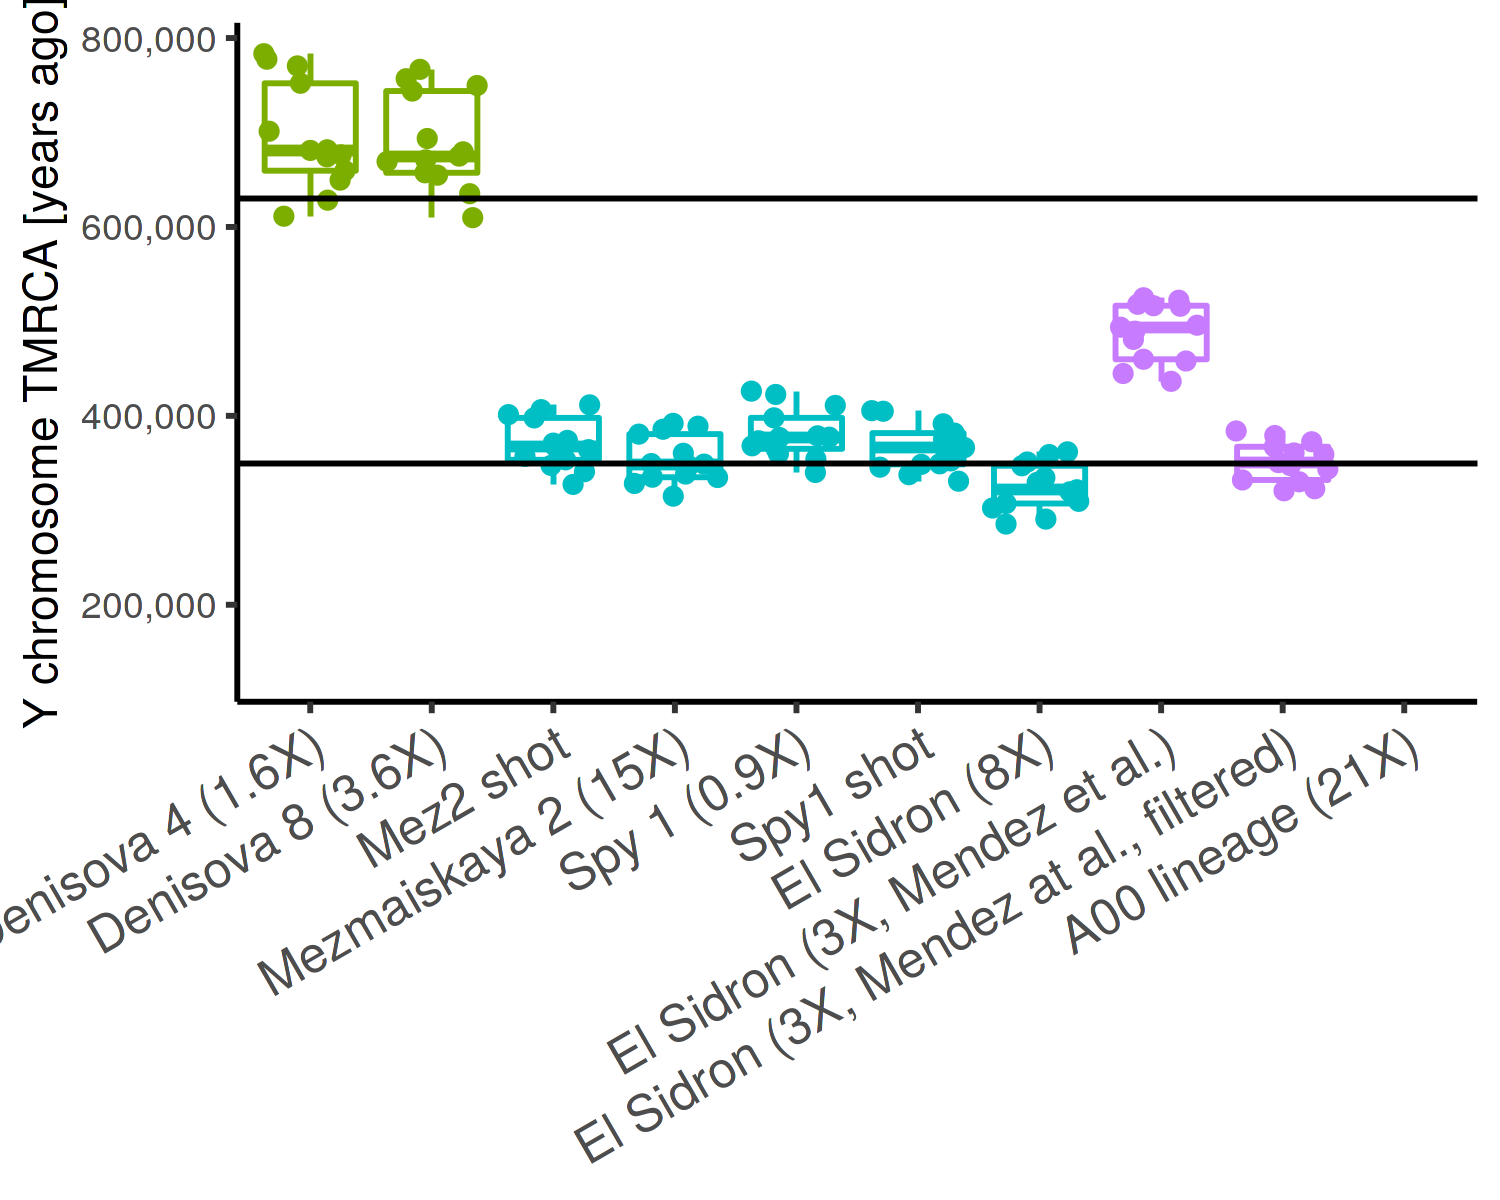

In [154]:
set_dim(5, 4)

tmrca %>%
ggplot(aes(name, tmrca_arch2, color = set)) +
    geom_boxplot() +
    geom_jitter() + 
    theme_classic() +
    xlab("") + ylab("Y chromosome TMRCA [years ago]") +
    expand_limits(y = 130000) +
    guides(color = guide_legend("archaic human")) +
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = c(630000, 350000)) +
    theme(legend.position = "none",
          axis.text.x = element_text(hjust = 1, angle = 30, size = 12),
          axis.title.x = element_blank())

In [86]:
x %<-% read_vcf("../data/vcf/full_shotgun_mez2.vcf.gz", mindp = 3, maxdp = 1)

In [87]:
y %<-% read_vcf("../data/vcf/full_mez2.vcf.gz", mindp = 3, maxdp = 1)

In [90]:
head(x)

chrom,pos,REF,ALT,shotgun_mez2
<chr>,<int>,<chr>,<chr>,<dbl>
Y,2649835,T,,0
Y,2649836,T,,0
Y,2649837,T,,0
Y,2649838,A,,0
Y,2649839,T,,0
Y,2649840,G,,0


In [91]:
df = full_join(x, y)

Joining, by = c("chrom", "pos", "REF", "ALT")


In [92]:
head(df)

chrom,pos,REF,ALT,shotgun_mez2,mez2
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
Y,2649835,T,,0,0
Y,2649836,T,,0,0
Y,2649837,T,,0,0
Y,2649838,A,,0,0
Y,2649839,T,,0,0
Y,2649840,G,,0,NA


In [93]:
filter(df, shotgun_mez2 != mez2)

chrom,pos,REF,ALT,shotgun_mez2,mez2
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
